## Some very standard (or standard for astro) packages

In [1]:
import subprocess
import os
import sys
import glob
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
import pandas as pd
import numdifftools as nd
import scipy.stats as ss
import arviz as az

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.modeling.powerlaws import BrokenPowerLaw1D
from astropy.constants import c

from scipy.special import iv
from scipy.optimize import curve_fit, differential_evolution

# Check if plots directory exists, if not create it
if not os.path.exists('plots'):
    os.makedirs('plots')

# My Version is: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
print(sys.version)

3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]


## Plotting and formatting functions/options

In [2]:
# Formatting opinions
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 9.0
mpl.rcParams['ytick.minor.size'] = .0

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.size'] = 9.0
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['xtick.labelbottom'] = True
mpl.rcParams['axes.linewidth'] = 1.5

# Function for putting UTC on top of axis
def FormatAxis(ax, mjd, dt = 10, interval=60):
    
    # For 1-D axis array
    if len(ax.shape) == 1:
        
        ax[0].set_xlabel('Observing Date (UTC)', fontfamily='serif')  
        ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
        ax[0].set_xlim(Time(mjd[0] - dt, format='mjd').datetime,Time(mjd[-1] + dt, format='mjd').datetime)
        ax[0].xaxis.set_label_position('top') 
        xformatter = mdates.DateFormatter('%Y-%m-%d')
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        ax[0].tick_params(axis='x', which='major',rotation=15, labeltop=True, labelbottom=False)
        xlabels = ax[0].get_xticklabels()
        ax[0].set_xticklabels(xlabels, rotation=15, ha='left')
    
        # Format secondary x-axis
        mjd_ax = ax[-1].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
        mjd_ax.set_xlabel('Observing Date (MJD)', fontfamily='serif')  
        mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0)
        plt.draw()
    
        # Extract the labels
        mjd_ticks = []
        labels = ax[0].get_xticklabels(which='major')
        for lab in labels:
            mjd_ticks.append(lab.get_text() + 'T00:00:00')
    
        # Line up MJD and Datetime labels 
        mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
        mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)

    # For 2-D axis array
    if len(ax.shape) == 2:
        for i in range(ax.shape[1]):
    
            ax[0, i].set_xlabel('Observing Date (UTC)', fontfamily='serif')  
            ax[0, i].xaxis.set_major_locator(mdates.DayLocator(interval=interval[i]))
            ax[0, i].set_xlim(Time(mjd[i][0] - dt[i], format='mjd').datetime,Time(mjd[i][-1] + dt[i], format='mjd').datetime)
            ax[0, i].xaxis.set_label_position('top') 
            xformatter = mdates.DateFormatter('%Y-%m-%d')
            plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
            ax[0, i].tick_params(axis='x', which='major',rotation=15, labeltop=True, labelbottom=False)
            xlabels = ax[0, i].get_xticklabels()
            ax[0, i].set_xticklabels(xlabels, rotation=15, ha='left')
    
            # Format secondary x-axis
            mjd_ax = ax[-1, i].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
            mjd_ax.set_xlabel('Observing Date (MJD)', fontfamily='serif')  
            mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0)
            plt.draw()

            # Extract the labels
            mjd_ticks = []
            labels = ax[0, i].get_xticklabels(which='major')
            for lab in labels:
                mjd_ticks.append(lab.get_text() + 'T00:00:00')
        
            # Line up MJD and Datetime labels 
            mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
            mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)
    
def plot2mjd(t):
    '''Convert from matplotlib plot date to mjd'''
    return Time(t, format="plot_date", scale='utc').mjd

def mjd2plot(mjd):
    '''Convert from mjd to matplotlib plot'''
    return Time(mjd, format="mjd", scale='utc').plot_date

# Stupid matplotlib sh*t from here -- https://stackoverflow.com/questions/46694889/matplotlib-sharex-with-colorbar-not-working
def align_axis_x(ax, ax_target):
    """Make x-axis of `ax` aligned with `ax_target` in figure"""
    posn_old, posn_target = ax.get_position(), ax_target.get_position()
    ax.set_position([posn_target.x0, posn_old.y0, posn_target.width, posn_old.height])

## Big radio light curve also highlighting the hard state times

/tmp/ipykernel_46049/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


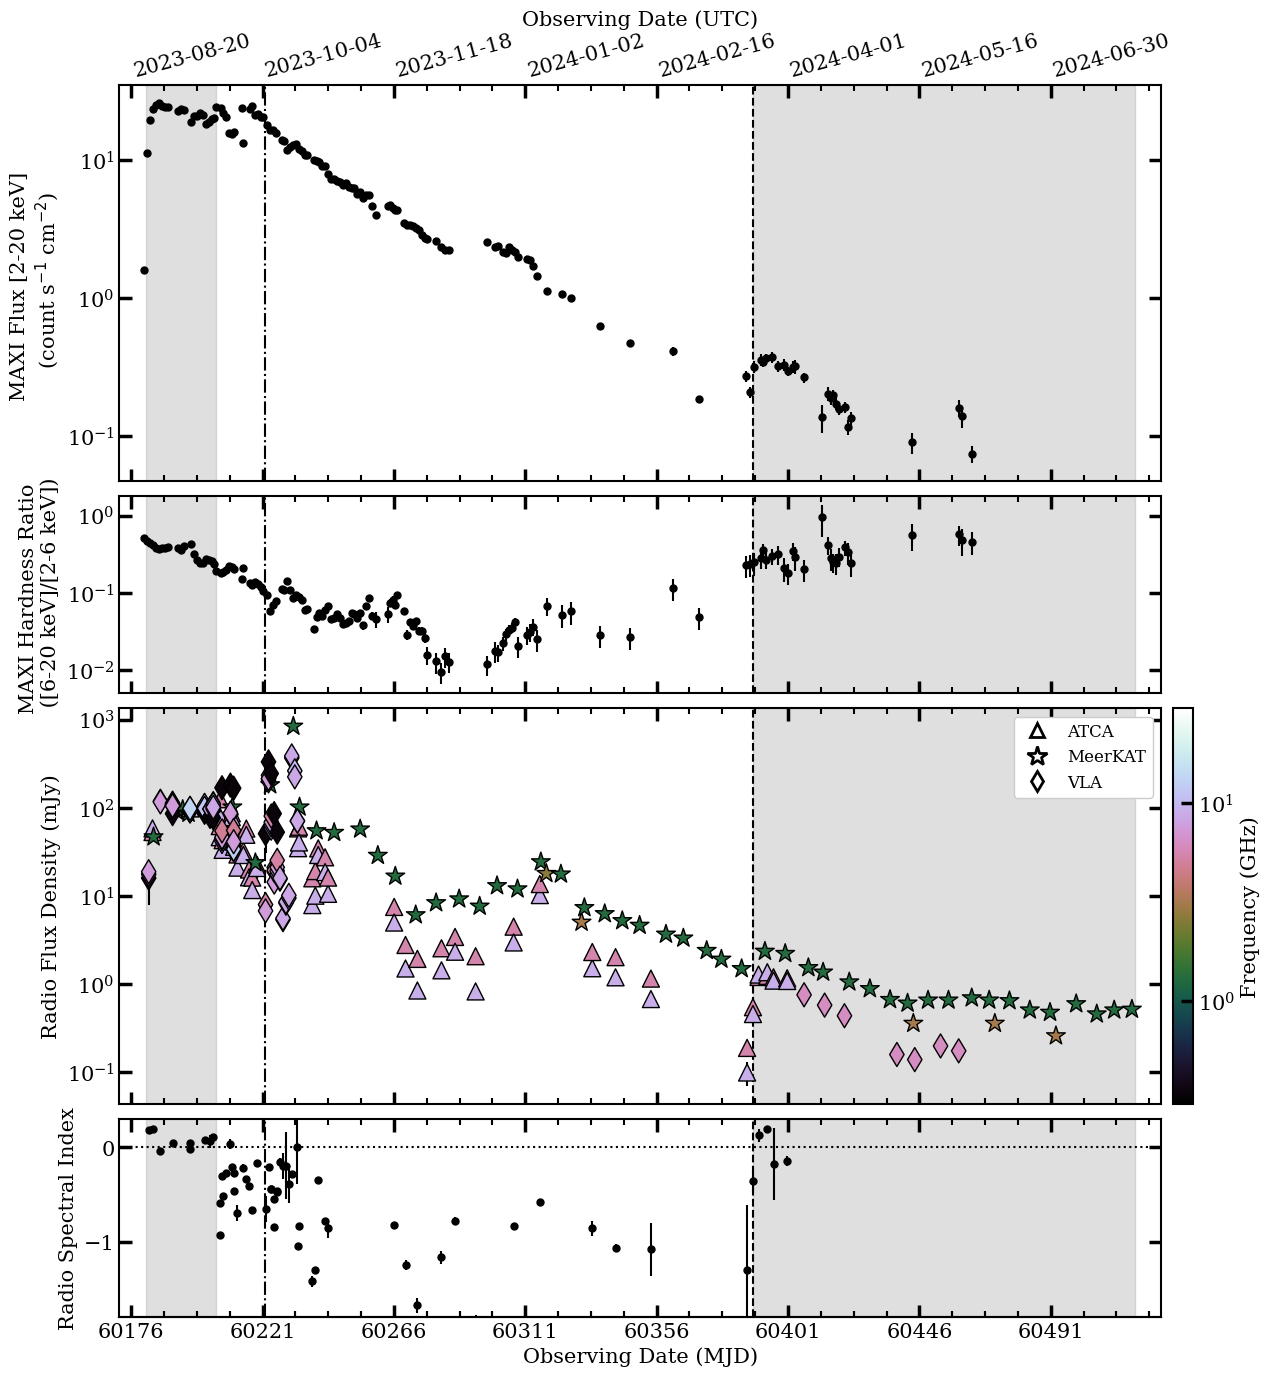

In [3]:
# ------------- #
# Load the Data #
# ------------- #

# Load MAXI/GSC data for X-ray flux and hardness ratio
maxi_data = np.load('SWJ1717_Files/MAXI_HID.npy')

# Load big data from Hughes et al. 2025 (submitted as of 2025 Mar 11)
big_data = pd.read_csv('SWJ1717_Files/SW1717_big_data.csv')
big_data['Midpoint (DT)'] = Time(big_data['Midpoint (MJD)'], format='mjd').datetime  # Convert MJD to datetime

# Load spectral indices for epochs with multi-band observations
big_alpha = np.genfromtxt('SWJ1717_Files/alpha_big_data.txt').T

# From the Hughes et al. 2025 paper, save the rising hard state alpha values (as its single component)
rise_alpha = big_alpha[:, big_alpha[0] < 60205]
np.savetxt('SWJ1717_Files/alpha_core_rise.txt', rise_alpha.T, header='Date (MJD), Spec. Index, Spec. Index Err')

# ------------- #
# Plot the Data #
# ------------- #

# Initialize a 4-panel plot with shared x-axis
fig, ax = plt.subplots(4, figsize=(16, 16), sharex=True, gridspec_kw={'hspace': 0.05, 'height_ratios': [1.0, 0.5, 1.0, 0.5]})
ax = np.atleast_1d(ax)  # Ensure `ax` is always an array

# Plot MAXI light curve (top panel)
ax[0].errorbar(Time(maxi_data[:, 0], format='mjd').datetime, maxi_data[:, 4], yerr=maxi_data[:, 5], fmt='o', mec='k', ecolor='k', color='k', ms=5)

# Plot MAXI hardness ratio (second panel)
ax[1].errorbar(Time(maxi_data[:, 0], format='mjd').datetime, maxi_data[:, 2], yerr=maxi_data[:, 3], fmt='o', mec='k', ecolor='k', color='k', ms=5)

# Define marker styles, sizes, and color map for radio data
symbol = ['o', 's', '^', '*', '<', 'd', '>']
ms = [150, 150, 150, 200, 150, 150, 150]
cm = mpl.colormaps['cubehelix']

# Plot radio flux densities (third panel)
for k, tele in enumerate(np.unique(big_data['Telescope'])):
    index = np.where(big_data['Telescope'] == tele)[0]

    # Only plot VLA, MeerKAT, and ATCA data (used for LrLx analysis)
    if tele in ['VLA', 'MeerKAT', 'ATCA']:
        cplt = ax[2].scatter(big_data['Midpoint (DT)'][index], big_data['Integrated flux (mJy)'][index],
                             c=big_data['Frequency (GHz)'][index], zorder=10000, ec='k', cmap=cm, norm='log',
                             s=ms[k], label=f'{tele}', marker=symbol[k], vmin=0.3, vmax=30.)
        ax[2].errorbar(big_data['Midpoint (DT)'][index], big_data['Integrated flux (mJy)'][index],
                       big_data['Error (mJy)'][index], fmt='.', ecolor='k')

# Plot spectral indices (bottom panel)
ax[3].errorbar(Time(big_alpha[0], format='mjd').datetime, big_alpha[1], big_alpha[2], fmt='o', mec='k', ecolor='k', color='k', ms=5)
ax[3].axhline(0.0, ls=':', c='k')  # Add a horizontal line at 0

# --------------- #
# Format the Plot #
# --------------- #

# Add legend for radio telescopes
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='ATCA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='MeerKAT', mec='k', mfc='w', mew=2, markersize=15),
    Line2D([0], [0], marker='d', color='w', label='VLA', mec='k', mfc='w', mew=2, markersize=10),
]

# Format individual panels
ax[0].set_ylabel('MAXI Flux [2-20 keV] \n (count s$^{-1}$ cm$^{-2}$)', fontfamily='serif')
ax[0].set_yscale('log')

ax[1].set_ylabel('MAXI Hardness Ratio \n ([6-20 keV]/[2-6 keV])', fontfamily='serif')
ax[1].set_yscale('log')

ax[2].legend(handles=legend_elements, fontsize=12, ncol=1, loc='upper right', framealpha=1.0)
ax[2].set_yscale('log')
ax[2].set_ylabel('Radio Flux Density (mJy)')

ax[3].set_ylabel('Radio Spectral Index')
ax[3].tick_params(labelbottom=False)

# Add color bar for radio frequencies
fig.colorbar(cplt, ax=ax[2], label="Frequency (GHz)", shrink=1, pad=0.01)

# Highlight state transitions and hard state times
for ax_i in ax:
    # State transitions from literature
    ax_i.axvline(Time(60389, format='mjd').datetime, ls='--', c='k')  # Soft --> Hard; Atel 16541
    ax_i.axvline(Time(60222, format='mjd').datetime, ls='-.', c='k')  # Hard --> Soft; Atel 16273

    # Highlight hard state times with shaded regions
    ax_i.axvspan(Time(big_data['Midpoint (MJD)'][0] - 1, format='mjd').datetime,
                 Time(big_data['Midpoint (MJD)'][86] - 1, format='mjd').datetime, color='grey', alpha=0.25)
    ax_i.axvspan(Time(60389, format='mjd').datetime,
                 Time(big_data['Midpoint (MJD)'][len(big_data['Midpoint (MJD)']) - 1] + 1, format='mjd').datetime,
                 color='grey', alpha=0.25)

# Format x-axis with UTC on top and MJD on bottom
ax[3].set_ylim(-1.8, 0.3)
FormatAxis(ax, np.array(big_data['Midpoint (MJD)']), interval=45)
align_axis_x(ax[0], ax[2])
align_axis_x(ax[1], ax[2])
align_axis_x(ax[3], ax[2])

# Show and save the plot
plt.savefig('plots/SW1717_LC.pdf', bbox_inches='tight')
plt.show()

## Plot the (hard state) radio and X-ray light curves before any data manipulation

/tmp/ipykernel_46049/892713787.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_xticklabels(xlabels, rotation=15, ha='left')
/tmp/ipykernel_46049/892713787.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_xticklabels(xlabels, rotation=15, ha='left')


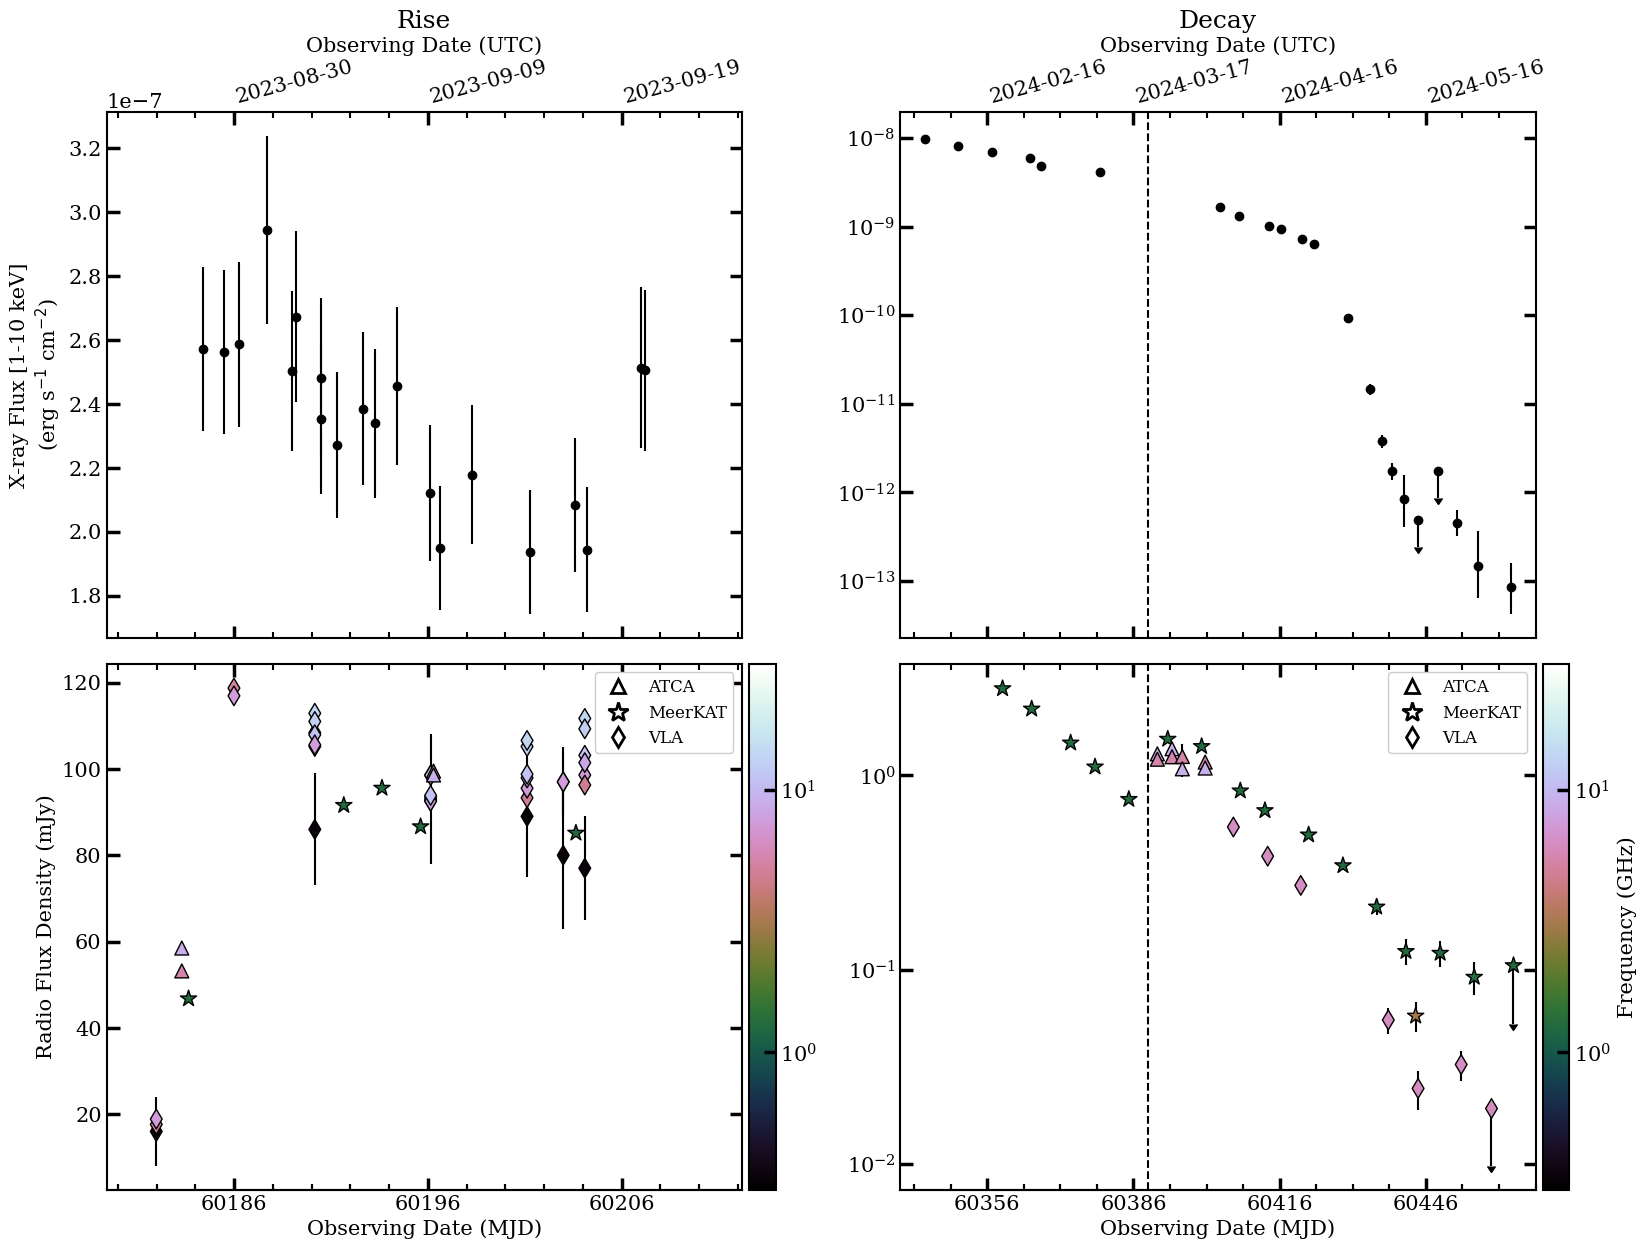

In [4]:
# This Notebook uses rise/decay in place for early/late or bright/faint or initial/final when describing which hard state is which; should be fairly straight forward

# ------------- #
# Load the Data #
# ------------- #

xrt_rise = np.genfromtxt('SWJ1717_Files/XRT_rise.txt', skip_header = 1).T
xrt_decay = np.genfromtxt('SWJ1717_Files/XRT_decay.txt', skip_header = 1).T

mkat_rise = np.genfromtxt('SWJ1717_Files/MeerKAT_core_rise.txt', skip_header = 1).T
mkat_decay = np.genfromtxt('SWJ1717_Files/MeerKAT_core_decay.txt', skip_header = 1).T

vla_rise = np.genfromtxt('SWJ1717_Files/VLA_core_rise.txt', skip_header = 1).T
vla_decay = np.genfromtxt('SWJ1717_Files/VLA_core_decay.txt', skip_header = 1).T

atca_rise = np.genfromtxt('SWJ1717_Files/ATCA_core_rise.txt', skip_header = 1).T
atca_decay = np.genfromtxt('SWJ1717_Files/ATCA_core_decay.txt', skip_header = 1).T

# ------------- #
# Plot the Data #
# ------------- #

# Initialise the plot
fig, ax = plt.subplots(2,2, figsize = (20,14), sharex='col', gridspec_kw={'hspace': 0.05, 'wspace':0.05})

# ----------
# ---- RISE

# MeerKAT 
arr = mkat_rise
sym  = '*'
size = 150 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# VLA 
arr = vla_rise
sym  = 'd'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)

# ATCA 
arr = atca_rise
sym  = '^'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# ---- XRT - This plots the X-ray flux (not the log10 flux)
arr = xrt_rise
dt = Time(arr[0], format='mjd').datetime
ax[0,0].errorbar(dt, arr[1], yerr = arr[4:6], fmt = 'o', color='k', label = 'Raw')

# ----------
# ---- DECAY

# ---- Radio

# MeerKAT 
arr = mkat_decay
sym  = '*'
size = 150 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# VLA 
arr = vla_decay
sym  = 'd'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)

# ATCA 
arr = atca_decay
sym  = '^'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# ---- XRT
arr = xrt_decay
dt = Time(arr[0], format='mjd').datetime
ulim = arr[-1].astype(bool)
ax[0,1].errorbar(dt[~ulim], arr[1][~ulim], yerr = arr[4:6,~ulim], fmt = 'o', color='k')
ax[0,1].errorbar(dt[ulim], arr[1][ulim], yerr = arr[1][ulim] * 0.5, mfc = 'k', fmt = 'o', uplims = True, color='k')


# State transition
ax[0,1].axvline(Time(60389, format='mjd').datetime, ls='--', c = 'k') # Soft --> Hard; Atel 16541 
ax[1,1].axvline(Time(60389, format='mjd').datetime, ls='--', c = 'k') # Soft --> Hard; Atel 16541 


# --------------- #
# Format the Plot #
# --------------- #

# Labelling
ax[1,0].set_ylabel('Radio Flux Density (mJy)')
ax[0,0].set_ylabel('X-ray Flux [1-10 keV]\n(erg s$^{-1}$ cm$^{-2}$)')
ax[0,0].set_title('Rise')
ax[0,1].set_title('Decay')

ax[1,0].legend(handles=legend_elements, fontsize=12, ncol=1, loc = 'upper right', framealpha = 1.0)
ax[1,1].legend(handles=legend_elements, fontsize=12, ncol=1, loc = 'upper right', framealpha = 1.0)


# Set the Scaling
ax[1,1].set_yscale('log')
ax[0,1].set_yscale('log')

# Include MJD (bottom) and Datetime (top)
ax[1,1].tick_params(labelbottom = False)
ax[1,0].tick_params(labelbottom = False)
FormatAxis(ax, [xrt_rise[0], xrt_decay[0]], dt = [5,5], interval= [10, 30])

# Colour bar formatting
fig.colorbar(cplt, ax=ax[1,0], shrink = 1, pad = 0.01)
fig.colorbar(cplt, ax=ax[1,1], shrink = 1, pad = 0.01, label="Frequency (GHz)")
align_axis_x(ax[0,0], ax[1,0])
align_axis_x(ax[0,1], ax[1,1])
plt.show()

## Simple function for two-point linear interpolation function assuming (Gaussian) error propogation

In [5]:
def two_point_linear_interpolation(xnew, data, method='linear'):
    """
    Perform two-point linear interpolation on a dataset with optional error propagation.

    This function takes in a dataset `data` containing x-values, y-values, and their associated 
    uncertainties (symmetric or asymmetric) and interpolates onto a new set of x-values (`xnew`). 
    The interpolation can be performed in either linear, logarithmic, or log10-linear space.

    The `linlog` method is specifically tailored for X-ray data where the input y-values are already 
    in log10 space. This method accounts for the asymmetry of X-ray error bars and returns both 
    interpolated log10 values and their corresponding linear-space values.

    Reference:
    - White 2017 (https://link.springer.com/article/10.1007/s10765-016-2174-6)

    Parameters:
    - xnew (array-like): The new x-values to interpolate onto.
    - data (array-like): The input data in the format:
        [x, y, dy] for symmetric errors or [x, y, dy_neg, dy_pos] for asymmetric errors.
        Shape: (3, N) or (4, N), where N is the number of data points.
        - For the `linlog` method, `y` should already be in log10 space.
    - method (str): The interpolation method, one of:
        - 'linear': Perform interpolation in linear space.
        - 'log': Perform interpolation in natural logarithmic space.
        - 'linlog': Perform interpolation in log10 space and return both log10 and linear-space values.

    Returns:
    - np.ndarray: Interpolated data in the format:
        - For 'linear' or 'log':
            [xnew, ynew, dynew_neg, dynew_pos, ulim] for asymmetric errors, or
            [xnew, ynew, dynew, ulim] for symmetric errors.
        - For 'linlog':
            Two arrays:
            1. Log10 flux: [xnew, ynew, dynew_neg, dynew_pos, ulim].
            2. Linear flux: [xnew, ylin, dylin_neg, dylin_pos, ulim].
        - xnew: Interpolated x-values.
        - ynew: Interpolated y-values (log10 or linear).
        - dynew_neg/dynew: Lower bound of the interpolated uncertainties.
        - dynew_pos: Upper bound of the interpolated uncertainties (for asymmetric errors).
        - ulim: Array of zeros indicating no upper limits.

    Raises:
    - TypeError: If input data is not a list or NumPy array.
    - TypeError: If input data does not have 3 or 4 rows.
    - TypeError: If the interpolation method is not 'linear', 'log', or 'linlog'.

    Notes:
    - If any values in `xnew` fall outside the range of `data[0]`, they are excluded.
    - The function enforces sorting of both `xnew` and `data` to ensure proper interpolation.
    - Uncertainties are propagated using the method described in White 2017 (Eq. 15).
    - The `linlog` method assumes the input y-values are already in log10 space.
    """

    # Ensure xnew is at least 1D
    xnew = np.atleast_1d(xnew)

    # Validate the input data type
    if isinstance(data, list):
        data = np.array(data)
    elif not isinstance(data, np.ndarray):
        raise TypeError('Input data should be a list or NumPy array.')

    # Validate the dimensions of the input data
    if data.shape[0] not in [3, 4]:
        raise TypeError('Input data should have 3 rows (symmetric errors) or 4 rows (asymmetric errors).')

    # Validate the interpolation method
    if method not in ['linear', 'log', 'linlog']:
        raise TypeError('Interpolation method must be either "linear", "log", or "linlog".')

    # Remove xnew values outside the range of data[0]
    valid_indices = (xnew >= data[0].min()) & (xnew <= data[0].max())
    xnew = xnew[valid_indices]

    # Sort xnew and data to ensure proper interpolation
    xnew = np.sort(xnew)
    data = data[:, data[0].argsort()]

    # Find the indices of the bounding points for each xnew
    hi = np.searchsorted(data[0], xnew)
    lo = hi - 1

    # Transform to natural logarithmic space if required
    if method == 'log':
        data[2:] = np.abs(data[2:] / data[1])  # Convert errors to fractional uncertainties
        data[1] = np.log(data[1])  # Take the natural logarithm of y-values

    # Perform linear interpolation (White 2017, Eq. 14)
    ynew = (
        data[1, lo] * (xnew - data[0, hi]) / (data[0, lo] - data[0, hi]) +  # L1 term
        data[1, hi] * (xnew - data[0, lo]) / (data[0, hi] - data[0, lo])    # L2 term
    )

    # Propagate uncertainties (White 2017, Eq. 15)
    dynew = (
        ((xnew - data[0, hi]) / (data[0, lo] - data[0, hi]) * data[2:, lo]) ** 2 +
        ((xnew - data[0, lo]) / (data[0, hi] - data[0, lo]) * data[2:, hi]) ** 2
    ) ** 0.5

    # Initialize upper limit array (all zeros, indicating no upper limits)
    ulim = np.zeros_like(ynew)

    # Handle the 'linlog' method
    if method == 'linlog':
        # Convert log10 interpolated values to linear space
        ylin = 10 ** ynew

        # Calculate linear-space errors using differences (to handle asymmetry)
        if data.shape[0] == 4:  # Asymmetric errors
            dylin = np.array([
                10 ** ynew - 10 ** (ynew - dynew[0]),  # Lower bound
                10 ** (ynew + dynew[1]) - 10 ** ynew   # Upper bound
            ])
        else:  # Symmetric errors
            dylin = np.array([10 ** ynew - 10 ** (ynew - dynew[0])])

        # Return both log10 and linear-space interpolated data
        return np.array([xnew, ynew, dynew[0], dynew[1], ulim]), np.array([xnew, ylin, dylin[0], dylin[1], ulim])

    # Convert back to linear space if interpolation was performed in natural log space
    if method == 'log':
        ynew = np.exp(ynew)
        dynew = ynew * dynew  # Scale uncertainties back to linear space

    # Return the interpolated data
    if dynew.shape[0] > 1:  # Asymmetric errors
        return np.array([xnew, ynew, dynew[0], dynew[1], ulim])
    else:  # Symmetric errors
        return np.array([xnew, ynew, dynew[0], ulim])

## Interpolate X-ray onto radio times (Save intermediate data products)

In [6]:
# Define a function to handle rise and decay interpolation
# Define a function to handle rise and decay interpolation
def interpolate_and_save(xrt_data, radio_times, output_file, header, method='log'):
    """
    Interpolate X-ray data onto radio observation times and save the results.

    Parameters:
    - xrt_data (np.ndarray): X-ray data array with columns [MJD, Flux, Sys Err neg, Sys Err pos, Upper Limit].
    - radio_times (list or np.ndarray): Radio observation times to interpolate onto.
    - output_file (str): Base path to save the interpolated data. For 'linlog', two files will be created.
    - header (str): Header for the output text file.
    - method (str): Interpolation method ('linear', 'log', or 'linlog').
    """
    # Concatenate and sort unique radio observation times
    xnew = np.sort(np.unique(np.concatenate(radio_times)))

    # Exclude upper limits from the X-ray data
    ulim = xrt_data[-1].astype(bool)
    data = xrt_data[:, ~ulim]
    data = data[[0, 6, 9, 10], :]  # Select MJD, logflux, log Sys Err neg, log Sys Err pos

    # Perform interpolation
    if method == 'linlog':
        # For 'linlog', get both log10 and linear flux interpolations
        log_flux, lin_flux = two_point_linear_interpolation(xnew, data, method=method)

        # Save log10 flux data
        np.savetxt(
            output_file.replace('.txt', '_log.txt'),
            np.array([log_flux[0], log_flux[1], log_flux[2], log_flux[3], log_flux[4]]).T,
            header=header.replace('Flux', 'Log10 Flux').replace('erg s^-1 cm^-2','')
        )

        # Save linear flux data
        np.savetxt(
            output_file.replace('.txt', '_lin.txt'),
            np.array([lin_flux[0], lin_flux[1], lin_flux[2], lin_flux[3], lin_flux[4]]).T,
            header=header
        )
    else:
        # For 'linear' or 'log', perform standard interpolation and save the result
        ynew = two_point_linear_interpolation(xnew, data, method=method)
        np.savetxt(
            output_file,
            np.array([ynew[0], ynew[1], ynew[2], ynew[3], ynew[4]]).T,
            header=header
        )
# ----------
# ---- RISE
interpolate_and_save(
    xrt_data=xrt_rise,
    radio_times=[mkat_rise[0], vla_rise[0], atca_rise[0]],
    output_file='SWJ1717_Files/XRT_rise_interp.txt',
    method = 'linlog',
    header='Date (MJD), Flux (erg s^-1 cm^-2), Sys Err neg (erg s^-1 cm^-2), Sys Err pos (erg s^-1 cm^-2), Upper Limit (True - 1, False - 0)'
)

# ----------
# ---- DECAY
interpolate_and_save(
    xrt_data=xrt_decay,
    radio_times=[mkat_decay[0, 5:], vla_decay[0], atca_decay[0]],
    output_file='SWJ1717_Files/XRT_decay_interp.txt',
    method = 'linlog',
    header='Date (MJD), Flux (erg s^-1 cm^-2), Sys Err neg (erg s^-1 cm^-2), Sys Err pos (erg s^-1 cm^-2), Upper Limit (True - 1, False - 0)'
)

## Plot the interpolated data

/tmp/ipykernel_46049/2796428960.py:116: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1400 with 6 Axes> than <Figure size 1000x800 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(cplt, ax=ax[1], shrink=1, pad=0.01, label="Frequency (GHz)")
/tmp/ipykernel_46049/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


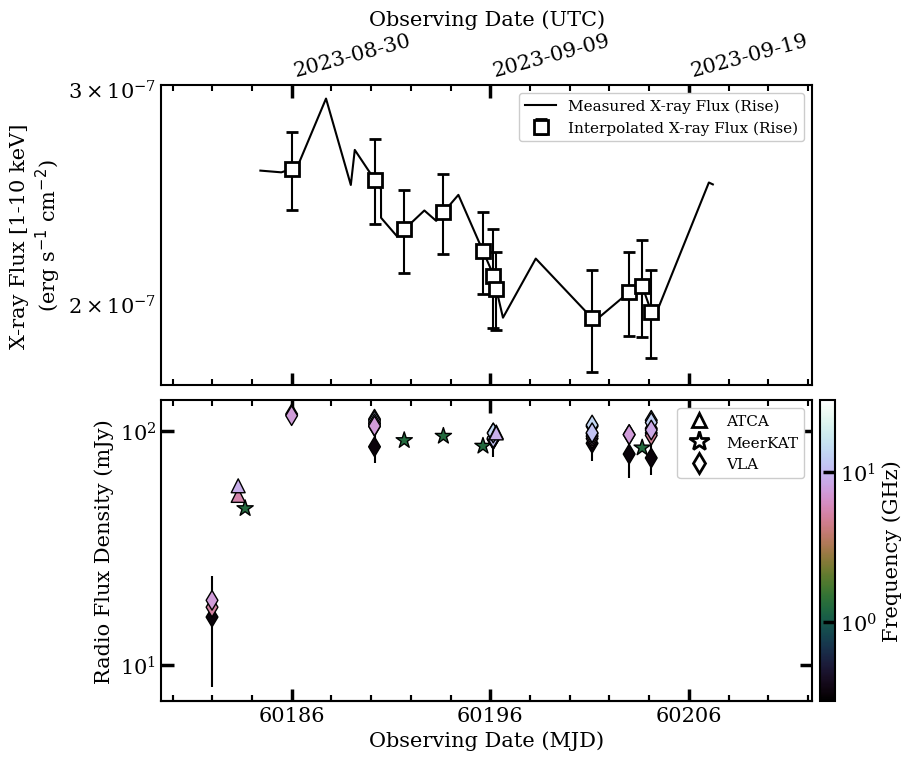

/tmp/ipykernel_46049/2796428960.py:140: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1400 with 6 Axes> than <Figure size 1000x800 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(cplt, ax=ax[1], shrink=1, pad=0.01, label="Frequency (GHz)")
/tmp/ipykernel_46049/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


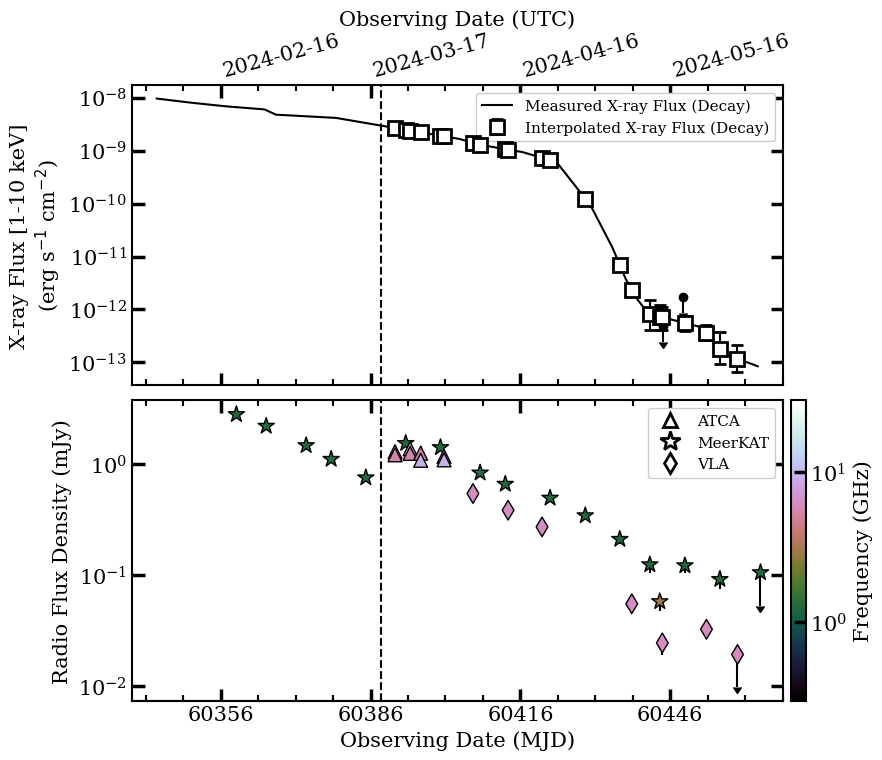

In [7]:
# ---------------- #
# Load the Data #
# ---------------- #

# Load X-ray data for rise and decay phases
xrt_rise = np.genfromtxt('SWJ1717_Files/XRT_rise.txt', skip_header=1).T  # Raw X-ray data (rise)
xrt_rise_interp = np.genfromtxt('SWJ1717_Files/XRT_rise_interp_lin.txt', skip_header=1).T  # Interpolated X-ray data (rise)
xrt_decay = np.genfromtxt('SWJ1717_Files/XRT_decay.txt', skip_header=1).T  # Raw X-ray data (decay)
xrt_decay_interp = np.genfromtxt('SWJ1717_Files/XRT_decay_interp_lin.txt', skip_header=1).T  # Interpolated X-ray data (decay)

# Load radio data for rise and decay phases
mkat_rise = np.genfromtxt('SWJ1717_Files/MeerKAT_core_rise.txt', skip_header=1).T
mkat_decay = np.genfromtxt('SWJ1717_Files/MeerKAT_core_decay.txt', skip_header=1).T
vla_rise = np.genfromtxt('SWJ1717_Files/VLA_core_rise.txt', skip_header=1).T
vla_decay = np.genfromtxt('SWJ1717_Files/VLA_core_decay.txt', skip_header=1).T
atca_rise = np.genfromtxt('SWJ1717_Files/ATCA_core_rise.txt', skip_header=1).T
atca_decay = np.genfromtxt('SWJ1717_Files/ATCA_core_decay.txt', skip_header=1).T

# ---------------- #
# Helper Functions #
# ---------------- #

def plot_xray(ax, xrt_data, xrt_interp, phase_label):
    """
    Plot X-ray data (raw and interpolated) for a given phase.

    Parameters:
    - ax (matplotlib.axes.Axes): Axes to plot on.
    - xrt_data (np.ndarray): Raw X-ray data.
    - xrt_interp (np.ndarray): Interpolated X-ray data.
    - phase_label (str): Label for the phase (e.g., 'Rise', 'Decay').
    """
    # Plot interpolated X-ray data
    arr = xrt_interp
    dt = Time(arr[0], format='mjd').datetime
    ax.errorbar(
        dt, arr[1], yerr=arr[2:4], fmt='s', color='k', mfc='w', ms=10,
        label=f'Interpolated X-ray Flux ({phase_label})', zorder=10000, mew=2, capsize=4
    )

    # Plot raw X-ray data
    arr = xrt_data
    dt = Time(arr[0], format='mjd').datetime
    ulim = arr[-1].astype(bool)
    ax.plot(dt[~ulim], arr[1][~ulim], ls='-', color='k', label=f'Measured X-ray Flux ({phase_label})')
    ax.errorbar(
        dt[ulim], arr[1][ulim], yerr=arr[1][ulim] * 0.5, mfc='k', fmt='o', uplims=True, color='k'
    )


def plot_radio(ax, radio_data, labels, symbols, sizes):
    """
    Plot radio data for multiple telescopes.

    Parameters:
    - ax (matplotlib.axes.Axes): Axes to plot on.
    - radio_data (list of np.ndarray): List of radio data arrays for different telescopes.
    - labels (list of str): Labels for the telescopes.
    - symbols (list of str): Marker symbols for the telescopes.
    - sizes (list of int): Marker sizes for the telescopes.
    """
    for arr, sym, size, label in zip(radio_data, symbols, sizes, labels):
        ulim = arr[-1].astype(bool)
        dt = Time(arr[0], format='mjd').datetime
        cplt = ax.scatter(
            dt[~ulim], arr[1][~ulim], c=arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm='log',
            s=size, marker=sym, vmin=0.3, vmax=30., label=label
        )  # Detections
        ax.errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt='.', ecolor='k')
        ax.scatter(
            dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c=arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm='log',
            s=size, marker=sym, vmin=0.3, vmax=30.
        )  # Upper limits
        ax.errorbar(
            dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]),
            fmt='.', ecolor='k', uplims=True
        )


def setup_plot(ax, ylabel, legend_elements=None):
    """
    Set up the plot with labels, legends, and scaling.

    Parameters:
    - ax (list of matplotlib.axes.Axes): List of axes to configure.
    - ylabel (str): Label for the y-axis.
    - legend_elements (list, optional): Custom legend elements for the plot.
    """
    ax[1].set_ylabel('Radio Flux Density (mJy)')
    ax[0].set_ylabel(ylabel)
    ax[1].legend(handles=legend_elements, fontsize=11, ncol=1, loc='upper right', framealpha=1.0)
    ax[0].legend(fontsize=11, ncol=1, loc='upper right', framealpha=1.0)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[1].tick_params(labelbottom=False)


# ---------------- #
# Plot the Rise Data #
# ---------------- #

# Initialize the plot for the rise phase
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0.05})

# Plot X-ray and radio data for the rise phase
plot_xray(ax[0], xrt_rise, xrt_rise_interp, 'Rise')
plot_radio(ax[1], [mkat_rise, vla_rise, atca_rise], ['MeerKAT', 'VLA', 'ATCA'], ['*', 'd', '^'], [150, 100, 100])

# Add labels, legends, and color bar
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='ATCA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='MeerKAT', mec='k', mfc='w', mew=2, markersize=15),
    Line2D([0], [0], marker='d', color='w', label='VLA', mec='k', mfc='w', mew=2, markersize=10),
]
setup_plot(ax, 'X-ray Flux [1-10 keV]\n(erg s$^{-1}$ cm$^{-2}$)', legend_elements)
fig.colorbar(cplt, ax=ax[1], shrink=1, pad=0.01, label="Frequency (GHz)")

# Format and align axes
FormatAxis(ax, xrt_rise[0], dt=5, interval=10)
align_axis_x(ax[0], ax[1])

# Save and show the rise plot
plt.savefig('plots/SWJ1717_Interp_Rise.pdf', bbox_inches='tight')
plt.show()


# ---------------- #
# Plot the Decay Data #
# ---------------- #

# Initialize the plot for the decay phase
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0.05})

# Plot X-ray and radio data for the decay phase
plot_xray(ax[0], xrt_decay, xrt_decay_interp, 'Decay')
plot_radio(ax[1], [mkat_decay, vla_decay, atca_decay], ['MeerKAT', 'VLA', 'ATCA'], ['*', 'd', '^'], [150, 100, 100])

# Add labels, legends, and color bar
setup_plot(ax, 'X-ray Flux [1-10 keV]\n(erg s$^{-1}$ cm$^{-2}$)', legend_elements)
fig.colorbar(cplt, ax=ax[1], shrink=1, pad=0.01, label="Frequency (GHz)")

# Highlight the soft-to-hard state transition (decay only)
transition_date = Time(60388, format='mjd').datetime
ax[0].axvline(transition_date, ls='--', c='k')
ax[1].axvline(transition_date, ls='--', c='k')

# Format and align axes
FormatAxis(ax, xrt_decay[0], dt=5, interval=30)
align_axis_x(ax[0], ax[1])

# Save and show the decay plot
plt.savefig('plots/SWJ1717_Interp_Decay.pdf', bbox_inches='tight')
plt.show()

## Solve for exponential decay during the soft state and subtract it out from the core flux density (save intermediate data products)

/tmp/ipykernel_46049/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


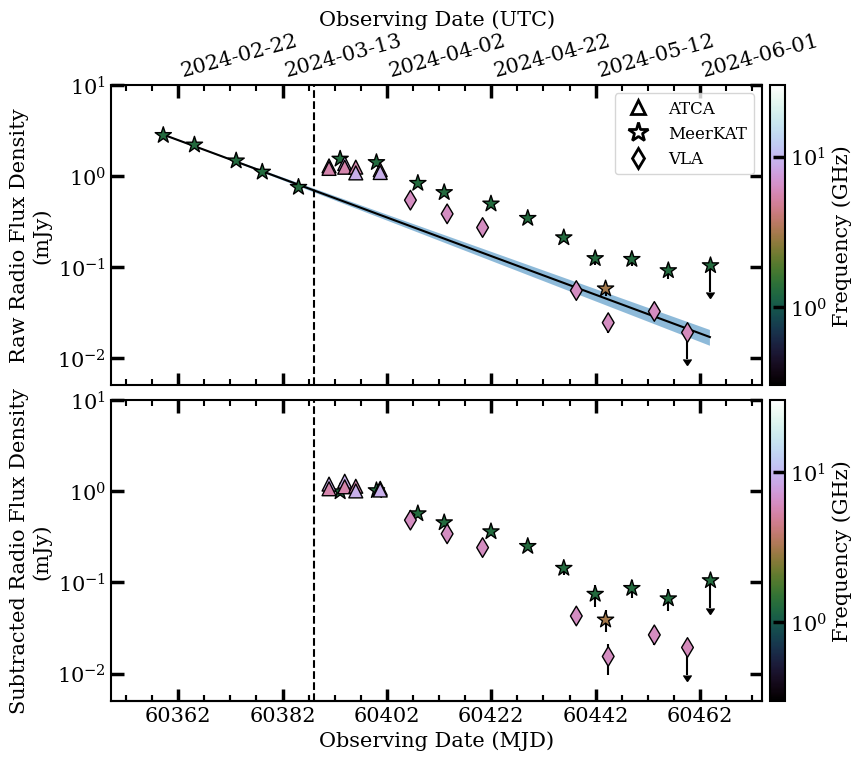

In [8]:
# --------------------------- #
# Solve for Exponential Decay #
# --------------------------- #

def exp_decay(x, A, tau):
    '''
    Exponential decay model.

    Parameters:
    - x (array): Time values (e.g., MJD).
    - A (float): Initial amplitude of the decay.
    - tau (float): Decay timescale.

    Returns:
    - array: Exponential decay values at each time point.
    '''
    return A * np.exp(-1. * (x - mkat_decay[0, 0]) / tau)


# Adapted from: https://stackoverflow.com/questions/79028892/how-to-get-errors-on-a-cubic-spline-interpolation-python-splrep-splev
def variance(model, x, p, Cp):
    '''
    Compute the variance of a model fit using the covariance matrix.

    Parameters:
    - model (function): The model function.
    - x (array): Input data points.
    - p (array): Best-fit parameters.
    - Cp (array): Covariance matrix of the fit.

    Returns:
    - array: Standard deviation (sigma) of the model predictions.
    '''
    def proxy(q):
        return model(x, *q)

    def projection(J):
        return J @ Cp @ J.T

    Jp = nd.Jacobian(proxy)(p)  # Compute the Jacobian
    Cy = np.apply_along_axis(projection, 1, Jp)

    # Return square root to get sigma
    return Cy ** 0.5


# --------------------------- #
# Fit Exponential Decay Model #
# --------------------------- #

# Extract data for fitting
x = mkat_decay[0, :5]  # Time values (MJD)
y = mkat_decay[1, :5]  # Flux density values (mJy)
dy = mkat_decay[2, :5]  # Flux density uncertainties (mJy)
xmod = np.linspace(mkat_decay[0].min(), mkat_decay[0].max(), 1000)  # Fine-grained time values for plotting

# Fit the exponential decay model
# Note: absolute_sigma=False scales errors conservatively based on relative values
popt, pcov = curve_fit(exp_decay, x, y, sigma=dy, absolute_sigma=False, p0=(7, 20))

# Compute confidence intervals for the fit
sigmamod = variance(exp_decay, xmod, popt, pcov)

# -------------------------------------------------- #
# Scale and Subtract Decay from Each Radio Telescope #
# -------------------------------------------------- #

# Make copies of the arrays for subtraction
mkat_sub = mkat_decay.copy()
vla_sub = vla_decay.copy()
atca_sub = atca_decay.copy()

# Subtract the exponential decay and propagate errors
# Exclude upper limits from subtraction (conservative assumption)
alpha_ejecta = -1.0

# MeerKAT
ulim = mkat_sub[-1].astype(bool)  # Identify upper limits
mkat_sub[1, ~ulim] -= exp_decay(mkat_sub[0, ~ulim], *popt) * (mkat_sub[-2, ~ulim] / 1.28) ** alpha_ejecta
mkat_sub[2, ~ulim] = np.sqrt(
    mkat_sub[2, ~ulim] ** 2 +
    (variance(exp_decay, mkat_sub[0, ~ulim], popt, pcov) * (mkat_sub[-2, ~ulim] / 1.28) ** alpha_ejecta) ** 2
)

# ATCA
ulim = atca_sub[-1].astype(bool)
atca_sub[1, ~ulim] -= exp_decay(atca_sub[0, ~ulim], *popt) * (atca_sub[-2, ~ulim] / 1.28) ** alpha_ejecta
atca_sub[2, ~ulim] = np.sqrt(
    atca_sub[2, ~ulim] ** 2 +
    (variance(exp_decay, atca_sub[0, ~ulim], popt, pcov) * (atca_sub[-2, ~ulim] / 1.28) ** alpha_ejecta) ** 2
)

# VLA
ulim = vla_sub[-1].astype(bool)
vla_sub[1, ~ulim] -= exp_decay(vla_sub[0, ~ulim], *popt) * (vla_sub[-2, ~ulim] / 1.28) ** alpha_ejecta
vla_sub[2, ~ulim] = np.sqrt(
    vla_sub[2, ~ulim] ** 2 +
    (variance(exp_decay, vla_sub[0, ~ulim], popt, pcov) * (vla_sub[-2, ~ulim] / 1.28) ** alpha_ejecta) ** 2
)

# -------------------------------- #
# Save the Subtracted Light Curves #
# -------------------------------- #

np.savetxt('SWJ1717_Files/ATCA_core_decay_sub.txt', atca_sub.T, header='Date (MJD), Peak (mJy), RMS (mJy), Freq (GHz), Upper Limit (True - 1, False - 0)')
np.savetxt('SWJ1717_Files/MeerKAT_core_decay_sub.txt', mkat_sub.T, header='Date (MJD), Peak (mJy), RMS (mJy), Freq (GHz), Upper Limit (True - 1, False - 0)')
np.savetxt('SWJ1717_Files/VLA_core_decay_sub.txt', vla_sub.T, header='Date (MJD), Peak (mJy), RMS (mJy), Freq (GHz), Upper Limit (True - 1, False - 0)')

# ------------------------------------------------ #
# Plot Exponential Fit and Subtracted Light Curves #
# ------------------------------------------------ #

# Initialize the plot
fig, ax = plt.subplots(2, figsize=(10, 8), sharex='col', gridspec_kw={'hspace': 0.05})

# Plot the exponential fit
ax[0].plot(Time(xmod, format='mjd').datetime, exp_decay(xmod, *popt), ls='-', c='k', zorder=10000, label='Exponential Fit')
ax[0].fill_between(
    Time(xmod, format='mjd').datetime,
    exp_decay(xmod, *popt) - sigmamod,
    exp_decay(xmod, *popt) + sigmamod,
    alpha=0.5,
    label=r"68% Confidence Interval"
)


# ---- MeerKAT
arr = mkat_decay
sym  = '*'
size = 150 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)

# ---- ATCA
arr = atca_decay
sym  = '^'
size = 100 
dt = Time(arr[0], format='mjd').datetime

cplt = ax[0].scatter(dt, arr[1], c = arr[-2], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt, arr[1], arr[2], fmt = '.', ecolor='k')

# ---- VLA
arr = vla_decay
sym  = 'd'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# -------------------------------------------------------------------------------------------------------------------------------------------
# Subtracted DATA

# ---- MeerKAT
arr = mkat_sub
sym  = '*'
size = 150 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime
cplt = ax[1].scatter(dt[~ulim][5:], arr[1][~ulim][5:], c = arr[-2][~ulim][5:], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[~ulim][5:], arr[1][~ulim][5:], arr[2][~ulim][5:], fmt = '.', ecolor='k')

cplt = ax[1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', c ='k', uplims=True)

# ---- ATCA
arr = atca_sub
sym  = '^'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime
cplt = ax[1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

# ---- VLA
arr = vla_sub
sym  = 'd'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime
cplt = ax[1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', c ='k', uplims=True)


# ---------- # 
# Formatting #
# ---------- #

for ax_i in ax:
    ax_i.axvline(Time(60388, format='mjd').datetime, ls='--', c = 'k') # Soft --> Hard; Atel 16541 

ax[0].set_yscale('log')
ax[0].set_ylim(5e-3, 10)
ax[0].legend(handles=legend_elements, fontsize=12, ncol=1)

ax[1].set_yscale('log')
ax[1].set_ylim(5e-3, 10)

ax[0].set_ylabel('Raw Radio Flux Density\n(mJy)')
ax[1].set_ylabel('Subtracted Radio Flux Density\n(mJy)')


fig.colorbar(cplt, ax=ax[0], label="Frequency (GHz)", shrink = 1, pad = 0.01)
fig.colorbar(cplt, ax=ax[1], label="Frequency (GHz)", shrink = 1, pad = 0.01)
align_axis_x(ax[1], ax[0])
ax[-1].tick_params(labelbottom = False)
FormatAxis(ax, [mkat_decay[0,0], mkat_decay[0,-1]], interval= 20)
plt.savefig('plots/SWJ1717_Exponential_Decay.pdf',bbox_inches='tight')
plt.show()


## Combine the X-ray and data fluxes into a single text files

In [9]:
# Re-load the X-ray data
xrt_decay_interp = np.genfromtxt('SWJ1717_Files/XRT_decay_interp_lin.txt', skip_header=1).T  # Interpolated X-ray data (decay)
xrt_rise_interp = np.genfromtxt('SWJ1717_Files/XRT_rise_interp_lin.txt', skip_header=1).T  # Interpolated X-ray data (rise)

# Stack the radio data, then sort it by time:

# Indices will be:
# ---- 0: Time (MJD)
# ---- 1: Flux Density (mJy)
# ---- 2: Flux Density Err (mJy)
# ---- 3: Flux Density Err (mJy - duplicate to match X-rays)
# ---- 4: Freq (GHz)
# ---- 5: Uplim? (Bool)

radio = np.hstack((mkat_rise, mkat_sub, vla_rise, vla_sub, atca_rise, atca_sub))
radio = radio[:, radio[0].argsort()] 
radio = np.array(radio[:3].tolist() + radio[2:].tolist())

# Add in a systematic on the radio flux error
f_sys = 0.1
radio[2:4] = (radio[2:4] ** 2 + (f_sys * radio[1]) ** 2) ** 0.5

# Stack the X-ray data, then sort it by time:

# Indices will be:
# ---- 0: Time (MJD)
# ---- 1: Flux (erg / cm^2 / s^-1)
# ---- 2: Flux Err Neg (erg / cm^2 / s^-1)
# ---- 3: Flux Err Pos (erg / cm^2 / s^-1)
# ---- 4: Uplim? (Bool)


# Stack and sort
xray = np.hstack((xrt_rise_interp, xrt_decay_interp))
xray = xray[:, xray[0].argsort()] 

# Make sure there is one-to-one mapping in time
radio = radio[:, np.isin(radio[0], xray[0])]

# Save the arrays
if len(np.unique(radio[0])) == len(xray[0]):
    np.savetxt('SWJ1717_Files/Xray_flux.txt', xray.T, header='Date (MJD), Flux (erg/cm^2/s), Flux Err neg (erg/cm^2/s), Flux Err pos (erg/cm^2/s), Upper Limit (True - 1, False - 0)')
    np.savetxt('SWJ1717_Files/radio_flux.txt', radio.T, header='Date (MJD), Flux Density (mJy), Flux Density Err (mJy), Flux Density Err (mJy), Freq (GHz), Upper Limit (True - 1, False - 0)')

else:
    print('The times are not matching; check the data!')

## Calculate the radio spectral indices during the decay

/tmp/ipykernel_46049/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


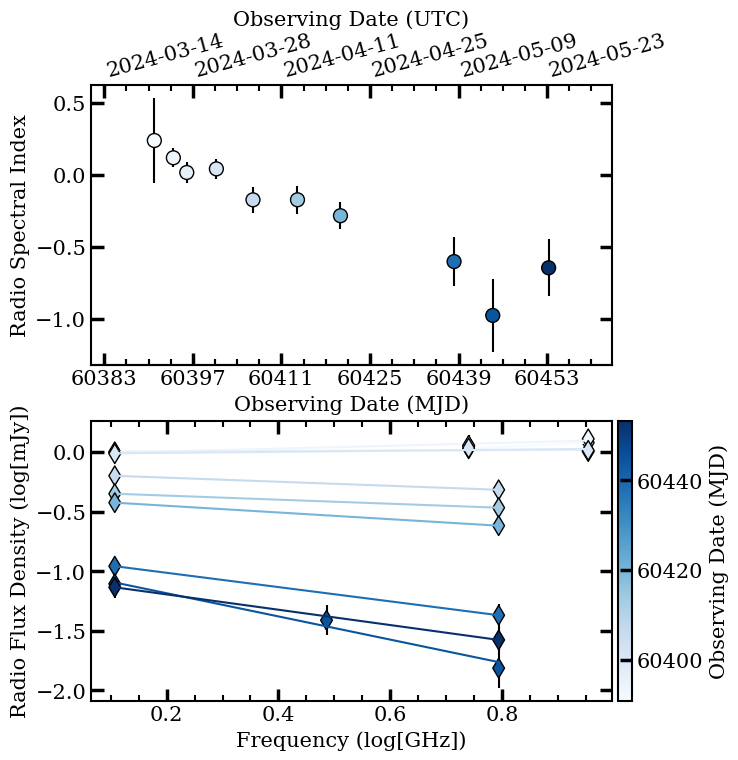

In [10]:
# Re-load the flux files 
xray_flux  = np.genfromtxt('SWJ1717_Files/Xray_flux.txt', skip_header = 1).T
radio_flux = np.genfromtxt('SWJ1717_Files/radio_flux.txt', skip_header = 1).T

# Interpolate the 1.28 GHz flux densities (during the decay) onto the other frequencies during the decay
mkat_index = (radio_flux[0] > 60360) & (radio_flux[-2] < 2.0) & (radio_flux[-1] < 1) # Only meerkat 1.28 GHz
time_index = (radio_flux[0] > 60360) & (radio_flux[-2] > 4.0) & (radio_flux[-1] < 1) # VLA/ATCA data
other_index = (radio_flux[0] > 60360) & (radio_flux[-2] > 2.0) & (radio_flux[-1] < 1) # VLA/ATCA/Meerkat[3.0GHz] data

radio_mkat_interp = two_point_linear_interpolation(np.unique(radio_flux[0,time_index]), radio_flux[0:4,mkat_index], method='log')
radio_mkat_interp[-1] = np.ones(radio_mkat_interp.shape[1]) * 1.28

# Make an array containing the working data to calculate spectral indices
working_data = np.hstack((radio_flux[:-1, other_index], radio_mkat_interp))
working_data = working_data[:, working_data[0].argsort()] 

# Initialize Arrays to save the values
alpha_decay_mjd = np.array([])
alpha_decay     = np.array([])
alpha_decay_err = np.array([])

# Initialize the figure
fig, ax = plt.subplots(2, figsize = (8,8))
ax = np.atleast_1d(ax)
cm = mpl.colormaps['Blues']

# Simple linear function for curve_fit:
def linear(x, m, b):
    return m * x + b

# Get unique times and counts
times, counts = np.unique(working_data[0], return_counts = True)

# Iterate through the (unique) times
for t, n in zip(times, counts):

    if n > 1:

        # Append time
        alpha_decay_mjd = np.append(alpha_decay_mjd, t)

        # Initialize arrays containing the logged freq/flux values
        y  = np.array([])
        x  = np.array([])
        dy = np.array([])

        # Append values but give one day of 'wiggle room'; All this does is include a single MeerKAT S-band observation one of the later spectral index calculations
        index = np.where(abs(working_data[0] - t) < 1)[0]
        x  = np.append(x,  np.log10(working_data[-1, index]))
        y  = np.append(y,  np.log10(working_data[1, index]))
        dy = np.append(dy, abs(working_data[2, index] / working_data[1,index] / np.log(10)))

        # Sort the arrays by frequency
        sort_index = np.argsort(x)
        x = x[sort_index]
        y = y[sort_index]
        dy = dy[sort_index]
    
        # Fit for the spectral indices and measure error from covariance
        fit, cov = curve_fit(linear, x, y, sigma = dy, absolute_sigma = True)

        # Append the spectral indices
        alpha_decay = np.append(alpha_decay, fit[0])
        alpha_decay_err = np.append(alpha_decay_err, cov[0,0] ** 0.5)
        
        # Plot the data
        cplt = ax[1].scatter(x, y, c = t * np.ones(x.size), zorder=10000, ec='k', cmap=cm, norm = 'linear', s = size, marker=sym, vmin=working_data[0].min(), vmax=working_data[0].max())
        ax[1].errorbar(x, y, dy, c = 'k', fmt = '.')

        # Plot the fit
        xmod = np.linspace(x.min(), x.max(), 3)
        ax[1].plot(xmod, fit[0] * xmod + fit[1], c = cplt.to_rgba(t), zorder=10000, ls='-')

# Finialize plot
fig.colorbar(cplt, ax=ax[1], label="Observing Date (MJD)", shrink = 1, pad = 0.01)
ax[0].scatter(Time(alpha_decay_mjd,format='mjd').datetime, alpha_decay, marker = 'o', s = 100, ec = 'k', c = cplt.to_rgba(alpha_decay_mjd), zorder = 1000)
ax[0].errorbar(Time(alpha_decay_mjd,format='mjd').datetime, alpha_decay, alpha_decay_err, fmt = '.', c = 'k')
ax[0].set_ylabel('Radio Spectral Index')
ax[1].set_ylabel('Radio Flux Density (log[mJy])')
ax[1].set_xlabel('Frequency (log[GHz])')

# Formatting nonsense
FormatAxis(np.array([ax[0]]), [alpha_decay_mjd[0], alpha_decay_mjd[-1]], interval= 14)
align_axis_x(ax[0], ax[1])
plt.savefig('plots/Decay_spectral_index.pdf', bbox_inches="tight")
plt.show()

# Save the decay spectral indices into a text file
decay_alpha = np.array([alpha_decay_mjd, alpha_decay, alpha_decay_err])
np.savetxt('SWJ1717_Files/alpha_core_decay.txt', decay_alpha.T, header = 'Date (MJD), Spec. Index, Spec. Index Err')

# Save the spectral (both rise and decay) into a single text file
# Load rise alpha
rise_alpha = np.genfromtxt('SWJ1717_Files/alpha_core_rise.txt', skip_header = 1).T

# Concat. the arrays
total_alpha = np.hstack((rise_alpha, decay_alpha))
np.savetxt('SWJ1717_Files/alpha_core.txt', total_alpha.T, header = 'Date (MJD), Spec. Index, Spec. Index Err')

## Calculate Radio and X-ray luminosities (save the data products)

In [11]:
# Re-load the flux files 
xray_flux  = np.genfromtxt('SWJ1717_Files/Xray_flux.txt', skip_header = 1).T
radio_flux = np.genfromtxt('SWJ1717_Files/radio_flux.txt', skip_header = 1).T

# Re-load the radio spectral index files
radio_alpha = np.genfromtxt('SWJ1717_Files/alpha_core.txt', skip_header = 1).T

# For times with multiple frequencies, use the one closest to 5 GHz to mitigate errors from spectral index scaling!
# This is a terrible way to do this (likely a more pythonic one) but whatever
index_5GHz = np.array([])
for t in np.unique(radio_flux[0]):

    radio_flux_t = radio_flux[:, radio_flux[0] == t]
    closest_freq = radio_flux_t[-2, np.argmin(abs(radio_flux_t[-2] - 5))]

    index_5GHz = np.append(index_5GHz, np.where((radio_flux[0] == t) & (radio_flux[-2] == closest_freq))[0])

# Trim array
radio_flux = radio_flux[:, index_5GHz.astype(int)]  

# Match the spectral indices closest in time -- it would be trivial to change this to instead:
# e.g., do more interpolation ?!?
# e.g., fit some relation (likely linear) to the spectral index vs. times plots
matched_alpha = np.array([radio_alpha[:, np.argmin(abs(t - radio_alpha[0]))] for t in radio_flux[0]]).T

# Calculate the luminosities and save to a text file -- label based on distance
D = 5.5 # kpc
# D = 2.2 # kpc -- '3xerr' from nominal position

# X-ray
lx = 4 * np.pi * xray_flux[1] * (D * 3.086e+21) ** 2
lx_neg, lx_pos = 4 * np.pi *  xray_flux[2:4] * (D * 3.086e+21) ** 2

# Radio
lr = 1e-26 * 4 * np.pi * 5.0e9 * (D * 3.086e+21) ** 2 * radio_flux[1] * (5.0 / radio_flux[-2]) ** matched_alpha[1]
lr_neg, lr_pos = 1e-26 * 4 * np.pi * 5.0e9 * (D * 3.086e+21) ** 2 * ((radio_flux[2:4] * (5.0 / radio_flux[-2]) ** matched_alpha[1]) ** 2 + (radio_flux[1] * (5.0 / radio_flux[-2]) ** (matched_alpha[1]) * np.log(5.0 / radio_flux[-2]) * matched_alpha[2]) ** 2) ** 0.5

# Save text file
data_arr = np.array([xray_flux[0], lx, lx_neg, lx_pos, lr, lr_neg, lr_pos, radio_flux[-1]]).T
np.savetxt('SWJ1717_Files/LRLX_{}kpc.txt'.format(str(D).replace('.','p')), data_arr, header = 'Date (MJD), Lx[1-10keV] (erg/s), Lx_neg[1-10keV] (erg/s), Lx_pos[1-10keV] (erg/s), Lr[5GHz] (erg/s), Lr_neg[5GHz] (erg/s),Lr_pos[5GHz] (erg/s), Lr_uplim (0 - no; 1 - yes)')

## Plot the LrLx without fitting power-laws

/home/andrewhughes/VirtualEnvironments/GenericPython3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


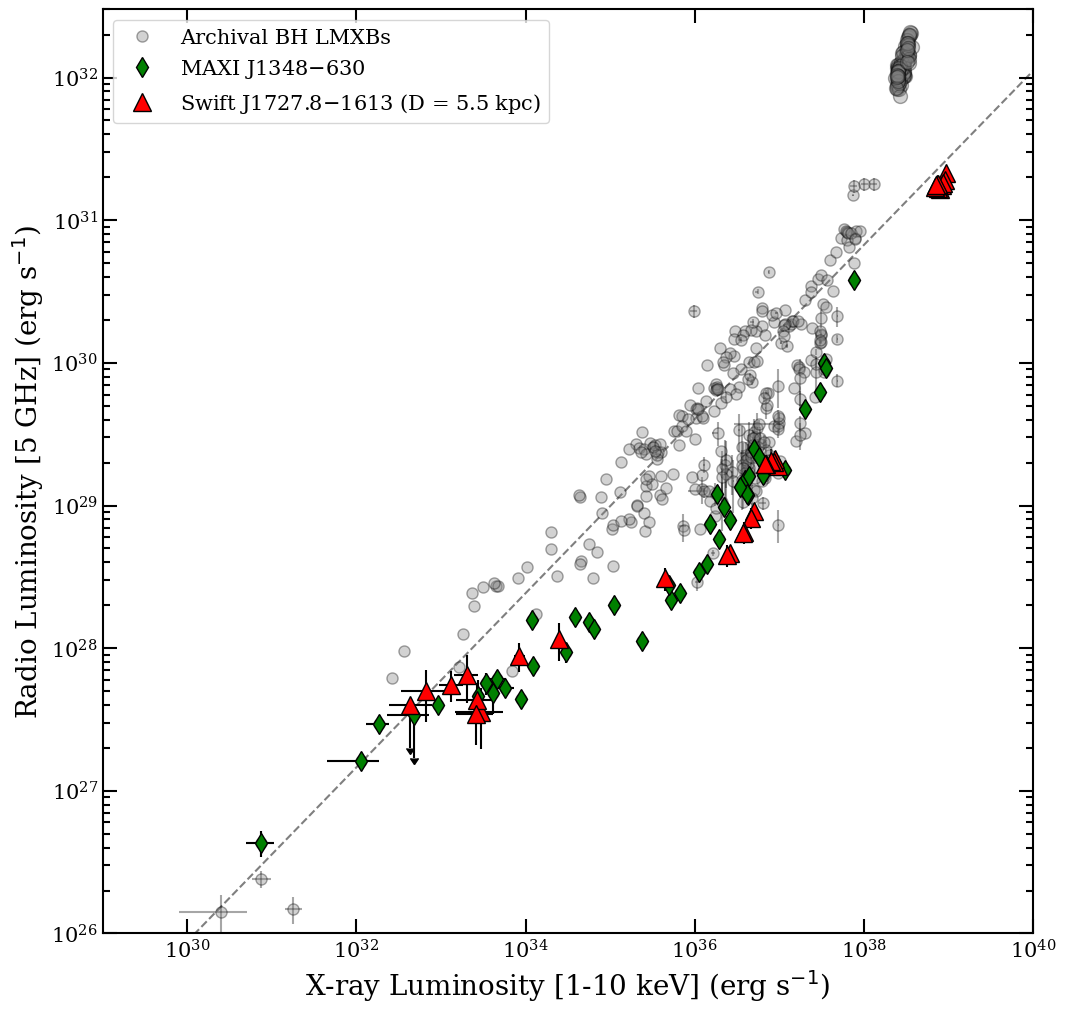

In [12]:
# Format basic axis + add axis labels
font_size=20
fig, ax = plt.subplots(figsize=(12,12))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e29, 1e40)
ax.set_ylim(1e26, 3e32)
ax.set_ylabel(r'Radio Luminosity [5 GHz] (erg s$^{-1}$)', fontsize= font_size, fontfamily='serif')
ax.set_xlabel(r'X-ray Luminosity [1-10 keV] (erg s$^{-1}$)', fontsize= font_size, fontfamily='serif')
ax.tick_params(axis='both', which='minor', direction='in',length=5,width=1.5,top=True,right=True)
ax.tick_params(axis='both', which='major', direction='in',length=10,width=1.5,top=True,right=True, labelsize=15)
ax.minorticks_on()

# Standard track
fit_x = np.logspace(25,45,num=10,base=10)
ax.loglog(fit_x,pow(10,(29.65+0.15-(0.61*36.32)))*pow(fit_x,0.61),'k--',zorder=1,alpha=0.5)

# ----------------------
# Archival sources from: https://github.com/bersavosh/XRB-LrLx_pub

# Load and plot the BH data
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')
ulim = (data['uplim'] == 'Lr')
ax.errorbar(data['Lx'][~ulim], data['Lr'][~ulim], xerr = [data['Lx_ler'][~ulim], data['Lx_uer'][~ulim]], yerr = [data['Lr_ler'][~ulim], data['Lr_uer'][~ulim]], fmt = 'o', color = 'k', mfc = 'grey', label = 'Archival BH LMXBs', ms = 8, alpha= 0.35)
ax.errorbar(data['Lx'][ulim], data['Lr'][ulim], yerr = data['Lr'][ulim] * 0.5, uplims = True, fmt = 'o', color = 'k', mfc = 'grey', ms = 7, alpha= 0.35)

# Highlight similarities with MAXI J1348
maxi = (data['Name'] == 'MAXI J1348-630')
ulim = (data[maxi]['uplim'] == 'Lr')

ax.errorbar(data['Lx'][maxi][~ulim], data['Lr'][maxi][~ulim], xerr = [data['Lx_ler'][maxi][~ulim], data['Lx_uer'][maxi][~ulim]], yerr = [data['Lr_ler'][maxi][~ulim], data['Lr_uer'][maxi][~ulim]], fmt = 'd', color = 'k', mfc = 'g', label = 'MAXI J1348$-$630', ms = 10, alpha= 1.0)
ax.errorbar(data['Lx'][maxi][ulim], data['Lr'][maxi][ulim], xerr = [data['Lx_ler'][maxi][ulim], data['Lx_uer'][maxi][ulim]], yerr = 0.5 * data['Lr'][maxi][ulim], fmt = 'd', color = 'k', mfc = 'g', uplims = True, ms = 10, alpha= 1.0)


# BH GRS 1915 (weird sources -- but x-ray bright)
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_oddsrcs.csv')
grs = (data['Name'] == 'GRS 1915+105')
ax.errorbar(data['Lx'][grs], data['Lr'][grs], xerr = [data['Lx_ler'][grs], data['Lx_uer'][grs]], yerr = [data['Lr_ler'][grs], data['Lr_uer'][grs]], fmt = 'o', color = 'k', mfc = 'grey', ms = 10, alpha= 0.35)

# -------------------
# Target: Swift J1727

swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
ulim = (swJ1727[-1] > 0.5)
ax.errorbar(swJ1727[1,~ulim], swJ1727[4,~ulim], xerr = swJ1727[2:4,~ulim], yerr = swJ1727[5:7,~ulim], fmt = '^', color = 'k', mfc = 'r', ms = 13, label = f'Swift J1727.8$-$1613 (D = {D} kpc)')
ax.errorbar(swJ1727[1,ulim], swJ1727[4,ulim] + 3 * swJ1727[5,ulim], xerr = swJ1727[2:4,ulim], yerr = 0.5 * (swJ1727[4,ulim] + 3 * swJ1727[5,ulim]), uplims = True, fmt = '^', color = 'k', mfc = 'r', ms = 13)

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles,labels, prop={'family':'serif', 'size':15})
plt.savefig('plots/LRLX.pdf')
plt.show()

## Fit broken power law 
### NOTE: fitting in linear space is SUPER Volatile as the residuals become highly non-normal due to the addition of systematic fractional errors (log-space) is better

Where a broken power-law is given by:

$$
    F_R = \begin{cases}
    A(L_X/L_{X,\text{tran}})^{\beta_\text{1}},& \text{if } L_X< L_{X,\text{tran}}\\
    A(L_X/L_{X,\text{tran}})^{\beta_\text{2}},& \text{if } L_X\geq L_{X,\text{tran}}
    \end{cases},
$$

and the single power-law is $F_R = AL_X^{\beta}$. The negative signs are because the (stupid) convention where `astropy` assumes the power law indices are negatives ?!?

Fit Results (DECAY):
beta1: 3.046e-01 +/- 2.030e-02
beta2: 1.422e+00 +/- 1.479e-01
Ltran_log: 3.163e+36 +/- 4.060e+35
Amp: 6.608e+01 +/- 1.087e-01

Fit Results (All DATA):
beta1: 3.175e-01 +/- 2.681e-02
beta2: 1.019e+00 +/- 1.200e-02
Ltran_log: 2.487e+36 +/- 5.001e+35
Amp: 6.610e+01 +/- 1.870e-01


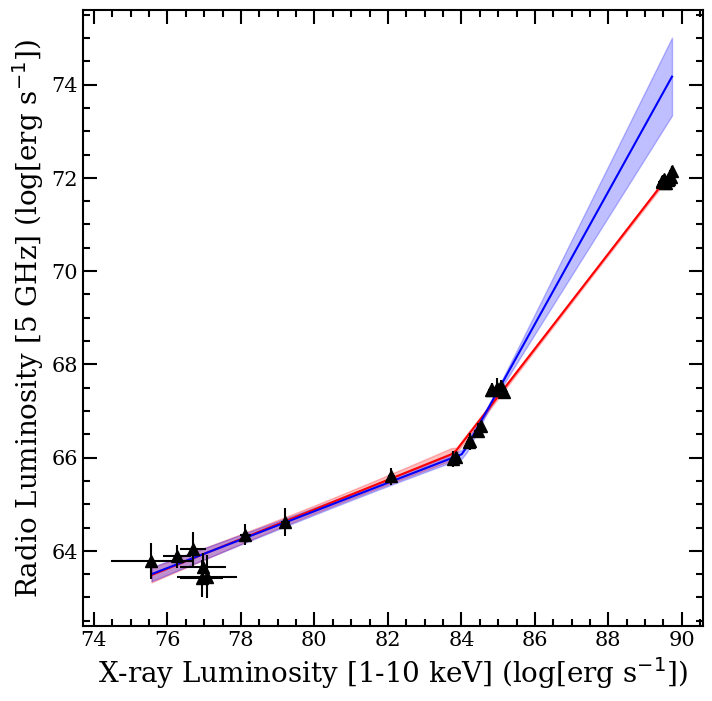

In [13]:
from scipy.odr import ODR, Model, RealData

# Define the broken power-law model in log space
def broken_plaw_log(B, Lx_log):
    """
    Broken power-law in log space.
    B[0]: beta1 (slope before the break)
    B[1]: beta2 (slope after the break)
    B[2]: Ltran_log (log of transition luminosity)
    B[3]: Amp (amplitude at the break)
    """
    beta1, beta2, Ltran_log, Amp = B
    result = np.zeros_like(Lx_log)
    mask = Lx_log < Ltran_log
    result[mask] = beta1 * (Lx_log[mask] - Ltran_log) + Amp
    result[~mask] = beta2 * (Lx_log[~mask] - Ltran_log) + Amp
    return result

# Adapted from: https://stackoverflow.com/questions/79028892/how-to-get-errors-on-a-cubic-spline-interpolation-python-splrep-splev
def variance(model, x, p, Cp):
    """
    Calculate the variance of the model predictions based on the covariance matrix of the parameters.

    Parameters:
    - model: The model function.
    - x: The independent variable values.
    - p: The best-fit parameters (array).
    - Cp: The covariance matrix of the parameters.

    Returns:
    - Variance of the model predictions.
    """
    def proxy(q):
        return model(q, x)  # Pass parameters as the first argument

    def projection(J):
        return J @ Cp @ J.T

    # Compute the Jacobian of the model with respect to the parameters
    Jp = nd.Jacobian(proxy)(p)

    # Compute the variance
    Cy = np.apply_along_axis(projection, 1, Jp)

    # Return square root to get sigma
    return Cy ** 0.5

# -------------------
# Fit only the decay
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = swJ1727[4] > 5e30
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables
x = np.log(swJ1727[1])  # Independent variable (log of X-ray luminosity)
y = np.log(swJ1727[4])  # Dependent variable (log of radio luminosity)
dy = np.abs(np.amax(swJ1727[5:7], axis=0) / swJ1727[4])  # Errors in y
dx = np.abs(np.amax(swJ1727[2:4], axis=0) / swJ1727[1])  # Errors in x

# Define the data for ODR
data = RealData(x, y, sx=dx, sy=dy)

# Define the model for ODR
model = Model(broken_plaw_log)

# Initialize the parameters [beta1, beta2, Ltran_log, Amp]
beta0 = [0.3, 1.4, np.log(1e36), 5.0]

# Set up the ODR
odr = ODR(data, model, beta0=beta0)

# Run the ODR fit
decay = odr.run()

# Print the fit results
print("Fit Results (DECAY):")
for param_name, param_value, param_error in zip(["beta1", "beta2", "Ltran_log", "Amp"], decay.beta, decay.sd_beta):
    if param_name == "Ltran_log":
        param_value = np.exp(param_value)
        param_error = param_value * param_error
    print(f"{param_name}: {param_value:.3e} +/- {param_error:.3e}")

# -------------------
# Fit all of the data
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = swJ1727[4] > 5e40
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables
x = np.log(swJ1727[1])  # Independent variable (log of X-ray luminosity)
y = np.log(swJ1727[4])  # Dependent variable (log of radio luminosity)
dy = np.abs(np.amax(swJ1727[5:7], axis=0) / swJ1727[4])  # Errors in y
dx = np.abs(np.amax(swJ1727[2:4], axis=0) / swJ1727[1])  # Errors in x

# Define the data for ODR
data = RealData(x, y, sx=dx, sy=dy)

# Define the model for ODR
model = Model(broken_plaw_log)

# Initialize the parameters [beta1, beta2, Ltran_log, Amp]
beta0 = [0.3, 1.4, np.log(1e36), 5.0]

# Set up the ODR
odr = ODR(data, model, beta0=beta0)

# Run the ODR fit
total = odr.run()

# Print the fit results
print("\nFit Results (All DATA):")
for param_name, param_value, param_error in zip(["beta1", "beta2", "Ltran_log", "Amp"], total.beta, total.sd_beta):
    if param_name == "Ltran_log":
        param_value = np.exp(param_value)
        param_error = param_value * param_error
    print(f"{param_name}: {param_value:.3e} +/- {param_error:.3e}")


# ---------------------------------
# Do a bit of comparative plotting
# ---------------------------------

# Reload the non-upper-limit data
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# Initialize plot
font_size = 20
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_ylabel(r"Radio Luminosity [5 GHz] (log[erg s$^{-1}$])", fontsize=font_size, fontfamily="serif")
ax.set_xlabel(r"X-ray Luminosity [1-10 keV] (log[erg s$^{-1}$])", fontsize=font_size, fontfamily="serif")
ax.tick_params(axis="both", which="minor", direction="in", length=5, width=1.5, top=True, right=True)
ax.tick_params(axis="both", which="major", direction="in", length=10, width=1.5, top=True, right=True, labelsize=15)
ax.minorticks_on()

# Plot SwJ1727 data
ax.errorbar(x, y, xerr=dx, yerr=dy, fmt="^", color="k", mfc="k", ms=8, zorder=10000)

# Broken Power Laws -- total
xmod = np.linspace(x.min(), x.max(), 100)
plt.plot(xmod, broken_plaw_log(total.beta, xmod), c="r", ls="-", zorder=1000)

# Plot the confidence interval
xmod = np.linspace(x.min(), x.max(), 100)
ax.fill_between(
    xmod,
    broken_plaw_log(total.beta, xmod) - variance(broken_plaw_log, xmod, total.beta, total.cov_beta),
    broken_plaw_log(total.beta, xmod) + variance(broken_plaw_log, xmod, total.beta, total.cov_beta),
    alpha=0.25,
    color="r",
    label=r"68% confidence interval",
)

# Broken Power Laws -- Decay
xmod = np.linspace(x.min(), x.max(), 100)
plt.plot(xmod, broken_plaw_log(decay.beta, xmod), c="b", ls="-", zorder=1000)

# Plot the confidence interval
xmod = np.linspace(x.min(), x.max(), 100)
ax.fill_between(
    xmod,
    broken_plaw_log(decay.beta, xmod) - variance(broken_plaw_log, xmod, decay.beta, decay.cov_beta),
    broken_plaw_log(decay.beta, xmod) + variance(broken_plaw_log, xmod, decay.beta, decay.cov_beta),
    alpha=0.25,
    color="b",
    label=r"68% confidence interval",
)

plt.show()


### Same as above (log-space fitting) but now inset into the LrLx diagram

Fit Results (DECAY):
beta1: 3.046e-01 +/- 2.030e-02
beta2: 1.422e+00 +/- 1.479e-01
Ltran_log: 3.163e+36 +/- 4.060e+35
Amp: 6.608e+01 +/- 1.087e-01

Fit Results (All DATA):
beta1: 3.175e-01 +/- 2.681e-02
beta2: 1.019e+00 +/- 1.200e-02
Ltran_log: 2.487e+36 +/- 5.001e+35
Amp: 6.610e+01 +/- 1.870e-01


/home/andrewhughes/VirtualEnvironments/GenericPython3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


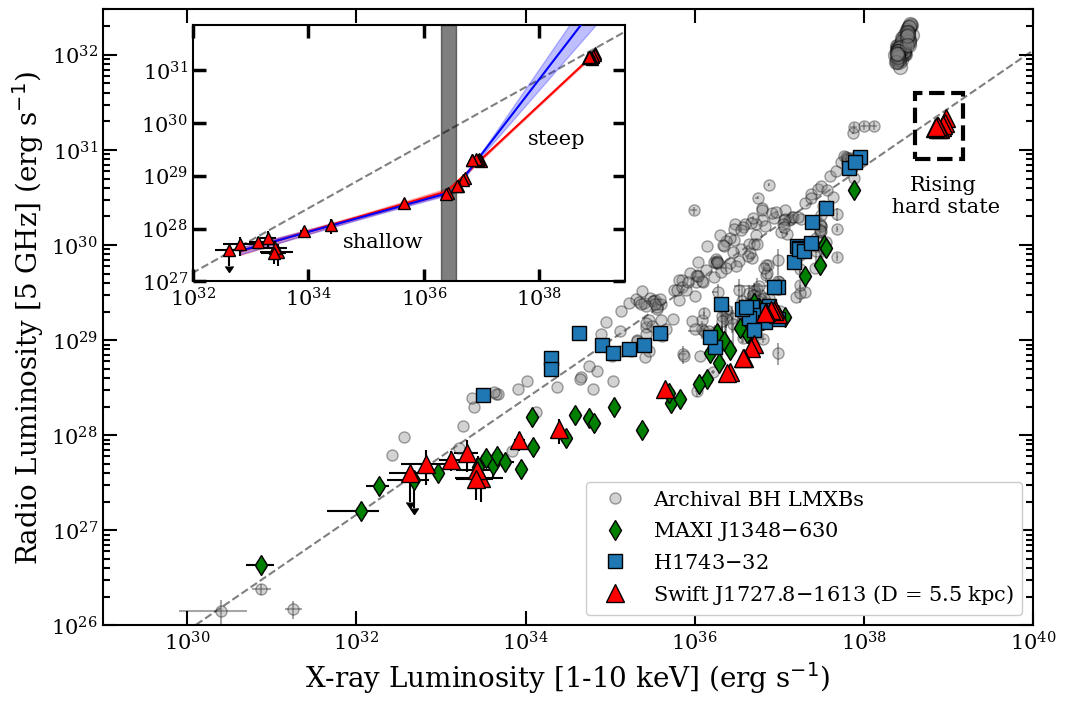

In [14]:
from scipy.odr import ODR, Model, RealData

# Define the broken power-law model in log space
def broken_plaw_log(B, Lx_log):
    """
    Broken power-law in log space.
    B[0]: beta1 (slope before the break)
    B[1]: beta2 (slope after the break)
    B[2]: Ltran_log (log of transition luminosity)
    B[3]: Amp (amplitude at the break)
    """
    beta1, beta2, Ltran_log, Amp = B
    result = np.zeros_like(Lx_log)
    mask = Lx_log < Ltran_log
    result[mask] = beta1 * (Lx_log[mask] - Ltran_log) + Amp
    result[~mask] = beta2 * (Lx_log[~mask] - Ltran_log) + Amp
    return result

# Adapted from: https://stackoverflow.com/questions/79028892/how-to-get-errors-on-a-cubic-spline-interpolation-python-splrep-splev
def variance(model, x, p, Cp):
    """
    Calculate the variance of the model predictions based on the covariance matrix of the parameters.

    Parameters:
    - model: The model function.
    - x: The independent variable values.
    - p: The best-fit parameters (array).
    - Cp: The covariance matrix of the parameters.

    Returns:
    - Variance of the model predictions.
    """
    def proxy(q):
        return model(q, x)  # Pass parameters as the first argument

    def projection(J):
        return J @ Cp @ J.T

    # Compute the Jacobian of the model with respect to the parameters
    Jp = nd.Jacobian(proxy)(p)

    # Compute the variance
    Cy = np.apply_along_axis(projection, 1, Jp)

    # Return square root to get sigma
    return Cy ** 0.5

# -------------------
# Fit only the decay
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = swJ1727[4] > 5e30
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables
x = np.log(swJ1727[1])  # Independent variable (log of X-ray luminosity)
y = np.log(swJ1727[4])  # Dependent variable (log of radio luminosity)
dy = np.abs(np.amax(swJ1727[5:7], axis=0) / swJ1727[4])  # Errors in y
dx = np.abs(np.amax(swJ1727[2:4], axis=0) / swJ1727[1])  # Errors in x

# Define the data for ODR
data = RealData(x, y, sx=dx, sy=dy)

# Define the model for ODR
model = Model(broken_plaw_log)

# Initialize the parameters [beta1, beta2, Ltran_log, Amp]
beta0 = [0.3, 1.4, np.log(1e36), 5.0]

# Set up the ODR
odr = ODR(data, model, beta0=beta0)

# Run the ODR fit
decay = odr.run()

# Print the fit results
print("Fit Results (DECAY):")
for param_name, param_value, param_error in zip(["beta1", "beta2", "Ltran_log", "Amp"], decay.beta, decay.sd_beta):
    if param_name == "Ltran_log":
        param_value = np.exp(param_value)
        param_error = param_value * param_error
    print(f"{param_name}: {param_value:.3e} +/- {param_error:.3e}")

# -------------------
# Fit all of the data
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = swJ1727[4] > 5e40
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables
x = np.log(swJ1727[1])  # Independent variable (log of X-ray luminosity)
y = np.log(swJ1727[4])  # Dependent variable (log of radio luminosity)
dy = np.abs(np.amax(swJ1727[5:7], axis=0) / swJ1727[4])  # Errors in y
dx = np.abs(np.amax(swJ1727[2:4], axis=0) / swJ1727[1])  # Errors in x

# Define the data for ODR
data = RealData(x, y, sx=dx, sy=dy)

# Define the model for ODR
model = Model(broken_plaw_log)

# Initialize the parameters [beta1, beta2, Ltran_log, Amp]
beta0 = [0.3, 1.4, np.log(1e36), 5.0]

# Set up the ODR
odr = ODR(data, model, beta0=beta0)

# Run the ODR fit
total = odr.run()

# Print the fit results
print("\nFit Results (All DATA):")
for param_name, param_value, param_error in zip(["beta1", "beta2", "Ltran_log", "Amp"], total.beta, total.sd_beta):
    if param_name == "Ltran_log":
        param_value = np.exp(param_value)
        param_error = param_value * param_error
    print(f"{param_name}: {param_value:.3e} +/- {param_error:.3e}")

# --------------------------------------------------------------------
# Make the final plots -- scaling to linear space and placing on LrLx
# --------------------------------------------------------------------

# Configure plot
font_size = 20
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e29, 1e40)
ax.set_ylim(1e26, 3e32)
ax.set_ylabel(r'Radio Luminosity [5 GHz] (erg s$^{-1}$)', fontsize=font_size, fontfamily='serif')
ax.set_xlabel(r'X-ray Luminosity [1-10 keV] (erg s$^{-1}$)', fontsize=font_size, fontfamily='serif')
ax.tick_params(axis='both', which='minor', direction='in', length=5, width=1.5, top=True, right=True)
ax.tick_params(axis='both', which='major', direction='in', length=10, width=1.5, top=True, right=True, labelsize=15)
ax.minorticks_on()

# Standard track
fit_x = np.logspace(25,45,num=10,base=10)
ax.loglog(fit_x,pow(10,(29.65+0.15-(0.61*36.32)))*pow(fit_x,0.61),'k--',zorder=1,alpha=0.5)

# Load and plot the BH data
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')
ulim = (data['uplim'] == 'Lr')
ax.errorbar(data['Lx'][~ulim], data['Lr'][~ulim], xerr = [data['Lx_ler'][~ulim], data['Lx_uer'][~ulim]], yerr = [data['Lr_ler'][~ulim], data['Lr_uer'][~ulim]], fmt = 'o', color = 'k', mfc = 'grey', label = 'Archival BH LMXBs', ms = 8, alpha= 0.35)
ax.errorbar(data['Lx'][ulim], data['Lr'][ulim], yerr = data['Lr'][ulim] * 0.5, uplims = True, fmt = 'o', color = 'k', mfc = 'grey', ms = 7, alpha= 0.35)

# Include BH GRS 1915 (weird sources -- but x-ray bright)
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_oddsrcs.csv')
grs = (data['Name'] == 'GRS 1915+105')
ax.errorbar(data['Lx'][grs], data['Lr'][grs], xerr = [data['Lx_ler'][grs], data['Lx_uer'][grs]], yerr = [data['Lr_ler'][grs], data['Lr_uer'][grs]], fmt = 'o', color = 'k', mfc = 'grey', ms = 10, alpha= 0.35)

# # Highlight  MAXI J1348
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')
maxi = (data['Name'] == 'MAXI J1348-630')
ulim = (data[maxi]['uplim'] == 'Lr')
ax.errorbar(data['Lx'][maxi][~ulim], data['Lr'][maxi][~ulim], xerr = [data['Lx_ler'][maxi][~ulim], data['Lx_uer'][maxi][~ulim]], yerr = [data['Lr_ler'][maxi][~ulim], data['Lr_uer'][maxi][~ulim]], fmt = 'd', color = 'k', mfc = 'g', label = 'MAXI J1348$-$630', ms = 10, alpha= 1.0)
ax.errorbar(data['Lx'][maxi][ulim], data['Lr'][maxi][ulim], xerr = [data['Lx_ler'][maxi][ulim], data['Lx_uer'][maxi][ulim]], yerr = 0.5 * data['Lr'][maxi][ulim], fmt = 'd', color = 'k', mfc = 'g', uplims = True, ms = 10, alpha= 1.0)

# # Highlight  H1743 32
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')
maxi = (data['Name'] == 'H 1743-322')
ulim = (data[maxi]['uplim'] == 'Lr')
ax.errorbar(data['Lx'][maxi][~ulim], data['Lr'][maxi][~ulim], xerr = [data['Lx_ler'][maxi][~ulim], data['Lx_uer'][maxi][~ulim]], yerr = [data['Lr_ler'][maxi][~ulim], data['Lr_uer'][maxi][~ulim]], fmt = 's', color = 'k', mfc = 'C0', label = 'H1743$-$32', ms = 10, alpha= 1.0)
ax.errorbar(data['Lx'][maxi][ulim], data['Lr'][maxi][ulim], xerr = [data['Lx_ler'][maxi][ulim], data['Lx_uer'][maxi][ulim]], yerr = 0.5 * data['Lr'][maxi][ulim], fmt = 's', color = 'k', mfc = 'C0', uplims = True, ms = 10, alpha= 1.0)


# Target: Swift J1727
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
ulim = (swJ1727[-1] > 0.5)
ax.errorbar(swJ1727[1,~ulim], swJ1727[4,~ulim], xerr = swJ1727[2:4,~ulim], yerr = swJ1727[5:7,~ulim], fmt = '^', color = 'k', mfc = 'r', ms = 13, label = 'Swift J1727.8$-$1613 (D = 5.5 kpc)')
ax.errorbar(swJ1727[1,ulim], swJ1727[4,ulim] + 3 * swJ1727[5,ulim], xerr = swJ1727[2:4,ulim], yerr = 0.5 * (swJ1727[4,ulim] + 3 * swJ1727[5,ulim]), uplims = True, fmt = '^', color = 'k', mfc = 'r', ms = 13)


# -------------------------------
# Inset panel to highlight fit  
# -------------------------------

left, bottom, width, height = [0.20, 0.54, 0.36, 0.32]
ax_inset = fig.add_axes([left, bottom, width, height])
ax_inset.set_yscale('log')
ax_inset.set_xscale('log')
ax_inset.minorticks_on()
ax_inset.set_xlim(1e32, 3e39)
ax_inset.set_ylim(1e27, 7e31)
ax_inset.loglog(fit_x, pow(10,(29.65+0.15-(0.61*36.32))) * pow(fit_x,0.61), 'k--', zorder=1, alpha=0.5)

# Plot SwJ1727 data
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
ulim = (swJ1727[-1] > 0.5)
ax_inset.errorbar(swJ1727[1,~ulim], swJ1727[4,~ulim], xerr = swJ1727[2:4,~ulim], yerr = swJ1727[5:7,~ulim], fmt = '^', color = 'k', mfc = 'r', ms = 8, label = 'Swift J1727.8$-$1613 (D = 5.5 kpc)', zorder=10000)
ax_inset.errorbar(swJ1727[1,ulim], swJ1727[4,ulim] + 3 * swJ1727[5,ulim], xerr = swJ1727[2:4,ulim], yerr = 0.5 * (swJ1727[4,ulim] + 3 * swJ1727[5,ulim]), uplims = True, fmt = '^', color = 'k', mfc = 'r', ms = 8, zorder=10000)


# Broken Power Laws -- total
xmod = np.linspace(x.min(), x.max(), 100)
ax_inset.plot(np.exp(xmod), np.exp(broken_plaw_log(total.beta, xmod)), c="r", ls="-", zorder=1000)

# Plot the confidence interval
ax_inset.fill_between(
    np.exp(xmod),
    np.exp(broken_plaw_log(total.beta, xmod) - variance(broken_plaw_log, xmod, total.beta, total.cov_beta)),
    np.exp(broken_plaw_log(total.beta, xmod) + variance(broken_plaw_log, xmod, total.beta, total.cov_beta)),
    alpha=0.25,
    color="r",
    label=r"68% confidence interval",
)

# Broken Power Laws -- Decay
ax_inset.plot(np.exp(xmod), np.exp(broken_plaw_log(decay.beta, xmod)), c="b", ls="-", zorder=1000)

# Plot the confidence interval
ax_inset.fill_between(
    np.exp(xmod),
    np.exp(broken_plaw_log(decay.beta, xmod) - variance(broken_plaw_log, xmod, decay.beta, decay.cov_beta)),
    np.exp(broken_plaw_log(decay.beta, xmod) + variance(broken_plaw_log, xmod, decay.beta, decay.cov_beta)),
    alpha=0.25,
    color="b",
    label=r"68% confidence interval",
)


# Add text to the inset panel
ax_inset.text(2e35, 5.5e27, "shallow", 
              fontsize=15, fontfamily='serif', color='black', ha='center', va='center')     
ax_inset.text(2e38, 5e29, "steep", 
              fontsize=15, fontfamily='serif', color='black', ha='center', va='center')   
ax_inset.axvspan(2.0e36,3.6e36, color='k', lw=1, ls='-', alpha=0.5)

# Add the rectangular box and label to the main plot
xmin = 4e38  # Minimum x-coordinate in data units
xmax = 1.5e39  # Maximum x-coordinate in data units
ymin = 0.8e31  # Minimum y-coordinate in data units
ymax = 4e31  # Maximum y-coordinate in data units

# Add the rectangle
rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                     edgecolor='k', facecolor='none', lw=3, ls ='--', zorder=10)
ax.add_patch(rect)

# Add the label below the rectangle
ax.text((xmin + xmax) / 2.2, ymin / 1.5, 'Rising\n hard state', color='k', fontsize=15, fontfamily='serif',
        ha='center', va='top', zorder=10)

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles,labels, prop={'family':'serif', 'size':15}, loc='lower right', framealpha = 1.0)
plt.savefig('plots/LRLX_inset.pdf')
plt.show()


## Black hole Mass Estimates

Here we are going to apply simply Monte-Carlo approach to estimate (minimum black hole masses) based on the accretion luminosity, 1--10 keV luminosities from the LRLX Catalog, and the best known distance estimates:

You can estimate the black hole mass by assuming that the maximum measured luminosity is some fraction ($f_\text{edd}$) of the Eddington luminosity: 

$$
L_\text{edd} = 1.26\times10^{38}\left(\frac{M}{M_\odot}\right){\rm\,erg\,s^{-1}}
$$

Such that:

$$
\tau_\text{bol}L_\text{max} = f_\text{edd}L_\text{edd} = 1.26\times10^{38}f_\text{edd}\left(\frac{M}{M_\odot}\right){\rm\,erg\,s^{-1}}
$$

where $\tau_\text{bol}$ is the bolometric correction (typical values between 3--8) to go from the band limited luminosity (1--10 keV) to the bolometric luminosity. Doing a little algebra you can get some mass estimates:

$$
M = 0.8\left(\frac{\tau_\text{bol}}{f_\text{edd}}\right)\left(\frac{L_\text{max}}{10^{38}{\rm\,erg\,s^{-1}}}\right)M_\odot
$$

from where we can conservatively assume $f_\text{edd}\equiv1$, a broad PDF $\tau_\text{bol}\sim\text{UNIFORM(3,8)}$, and the reported distance probability distribution(s) (assuming Guassians? Maybe?) to measure most likely black hole masses. The codes are arxiv codes for references


### Distance estimates:

1. GX 339-4:  $\sim$ 8-12kpc (probably uniform, 1904.07803)
2. H1743-32: 8.5 $\pm $ 0.8kpc (1111.2388: although the errors are not symmetric, we could adopt a more conservative uniform distribution of 5--10kpc)
3. V404Cyg: 2.39 $\pm $ 0.14kpc (0910.5253)
4. Swift J1753: $\sim 8.42_{-2.85}^{+4.32}$ kpc heavily skewed distribution (1804.11349)
5. MAXI J1348: $\sim2.2_{-0.6}^{+0.5}$ (2009.14419) and 3.39 $\pm$ 0.34(2012.11754)
6. XTE J1118+480: $\sim 8.22_{-6.71}^{+9.26}$ kpc heavily skewed distribution (1804.11349) historic distance is 1.7 $\pm$ 0.1 kpc (astro-ph/0601409)
7. XTE J1752-223: $\sim 3.5$ kpc (1008.0597) between $\sim 3.5-8$ kpc (1204.2735) or much more unconstraining of $\sim$ 2-20 kpc (1109.1378)
8. MAXI J1836-194 $\sim 4-10$ kpc (1312.5822) however upper limit assumes BH mass; replace with 20 kpc (limit of galactic size)

### Distances used in LRLX

1. GX 339-4: 8 kpc (1211.1600)
2. H1743-32: 8 kpc (1101.5159)
3. V404Cyg: 2.39  (0910.5253)
4. Swift J1753: 8 kpc (1709.05242)
5. MAXI J1348: 2.2 kpc (2105.06006)
6. XTE J1118+480: 1.7 kpc (abs/1003.5516 and abs/1408.3130)
7. XTE J1752-223: 8 kpc (1303.6702 and 1204.2735)
8. MAXI J1836-194: 10 kpc (1503.08634: Looks like it from here)

### BH Mass estimates:

1. GX 339-4: $\sim$ 4-11 $M_\odot$ (1904.07803)
2. H1743-32: $\sim$ 9-14 $M_\odot$ (1901.00810)
3. V404Cyg: $\sim9_{-0.6}^{+0.2}M_\odot$ (1004.5358, although there is some contention, as the inclination may be lower, 10.1093/mnras/265.4.834)
4. Swift J1753: $>7.4\pm1.2M_\odot$ (1608.04969)
5. MAXI J1348: $11\pm 2M_\odot$ (2012.11754) or $14.8\pm0.9M_\odot$ (2211.06271) or $8.7\pm0.3M_\odot$ (10.1093/mnras/stac1170)
6. XTE J1118+480: 8.5 $\pm$ 0.63 $M_\odot$ (astro-ph/0601409) seems optimistic other estimates are 6.9-8.2 $M_\odot$ (1211.2786) or 7-7.4 $M_\odot$ (1909.06358) or 6.25-7.49 $M_\odot$ (1803.09438) so 5-10 $M_\odot$ seems like a decent range
7. XTE J1752-223: $\sim$ 8-11 $M_\odot$ (1008.0597) or much more unconstraining of $\sim$ 5-55 $M_\odot$ (1109.1378)
8. MAXI J1836-194: $\sim$ 5-12 $M_\odot$ (1312.5821)


## For the BH LMXBs with (heavily skewed) best distance estimates from 1804.11349, see if we can get decent reproductions adopting (ad hoc) a $\beta$-distribution. 

Below are some of the distributions we are trying to match -- so our fits should look similar(ish):

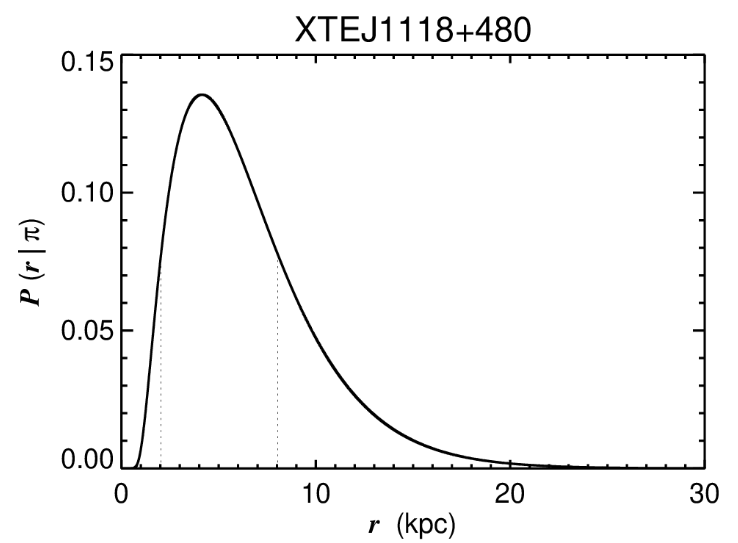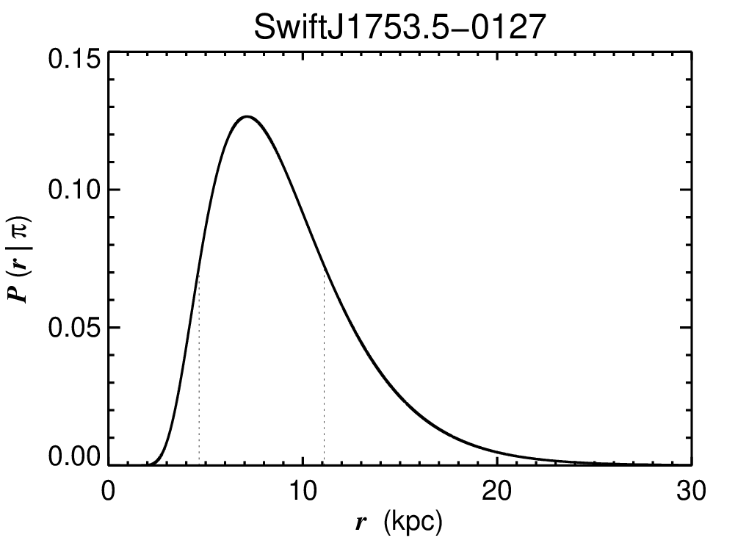

XTE J1118+480 Mode:  4.330729516109771
XTE J1118+480 HDI:  [2.06438381 8.03082642]
XTE J1118+480 Errors:  [-2.26634571  3.7000969 ]
Swift J1753.5-0127 Mode:  7.076557671632169
Swift J1753.5-0127 HDI:  [ 4.62904202 11.00319378]
Swift J1753.5-0127 Errors:  [-2.44751565  3.92663611]


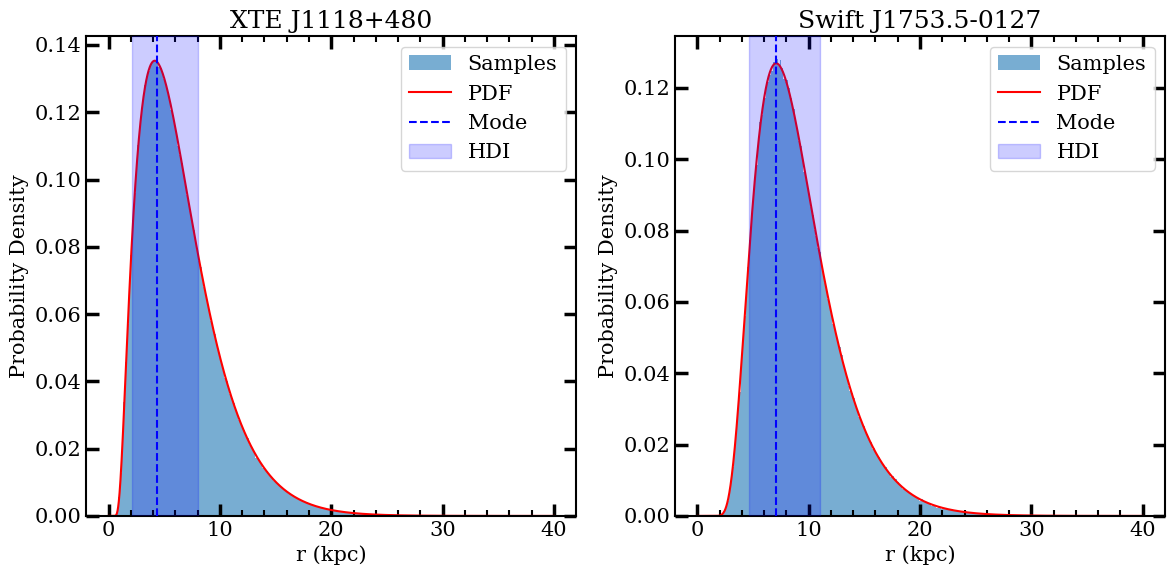

In [15]:
# Class to handle the custom distribution using rejection sampling 
class CustomDistribution:
    def __init__(self, f, r, **kwargs):
        """
        Initialize the custom distribution using rejection sampling.

        Parameters:
        - f: The function to treat as a probability distribution (un-normalized).
        - r: The range of r values (1D numpy array).
        - **kwargs: Additional arguments to pass to the function f.
        """
        self.f = f
        self.r = r
        self.kwargs = kwargs

        # Evaluate the function over the range of r
        self.f_values = f(r, **kwargs)

        # Normalize the function to make it a valid probability distribution
        self.normalization_constant = np.trapz(self.f_values, r)  # Compute the integral
        self.f_values /= self.normalization_constant  # Normalize the PDF

        # Find the maximum value of the normalized PDF for rejection sampling
        self.max_pdf = np.max(self.f_values)

    def pdf(self, r):
        """
        Return the probability density function (PDF) at the given r values.

        Parameters:
        - r: The r values to evaluate the PDF.

        Returns:
        - PDF values at the given r values.
        """
        return self.f(r, **self.kwargs) / self.normalization_constant

    def rvs(self, size=1000):
        """
        Generate random samples from the distribution using rejection sampling.

        Parameters:
        - size: Number of samples to generate.

        Returns:
        - Random samples from the distribution.
        """
        samples = []
        while len(samples) < size:
            # Generate a random candidate r value uniformly from the range
            r_candidate = np.random.uniform(self.r[0], self.r[-1])

            # Generate a random value uniformly between 0 and max_pdf
            u = np.random.uniform(0, self.max_pdf)

            # Evaluate the PDF at the candidate r value
            pdf_value = self.pdf(r_candidate)

            # Accept the sample if u <= pdf_value
            if u <= pdf_value:
                samples.append(r_candidate)

        return np.array(samples)

def likelihood(r, pi, dpi):
    """
    The likelihood function from 1804.11349.

    Parameters:
    - r: The distance values (1D numpy array).
    - pi: The Gaia parallax (in mas).
    - dpi: The uncertainty in the parallax (in mas).
    
    Returns:
    - The likelihood values at the given r values.
    """
    # Characteristic scale length for the Galactic distribution of stars
    L = 2.17  # in kpc (error is 0.12 kpc)

    # Likelihood function: Gaussian distribution for parallax
    likelihood = 1.0 / (np.sqrt(2 * np.pi) * dpi) * np.exp(-1 / (2 * dpi ** 2) * (pi - 1 / r) ** 2)
    
    # Prior function: Galactic prior for distance distribution
    prior = 1.0 / 2 / L ** 3 * r ** 2 * np.exp(-r / L)

    # Combine the likelihood and prior to get the un-normalized posterior
    return likelihood * prior

def compute_hdi_and_mode(samples, hdi_prob=0.68):
    """
    Compute the highest density interval (HDI) and mode of a distribution.

    Parameters:
    - samples: Array of samples from the distribution.
    - hdi_prob: The desired credible interval (default is 0.68 for 68%).

    Returns:
    - hdi: A tuple containing the lower and upper bounds of the HDI.
    - mode: The mode of the distribution.
    """
    # Compute the HDI using arviz
    hdi = az.hdi(samples, hdi_prob=hdi_prob)

    # Compute the mode using arviz's calculate_point_estimate
    mode = az.plots.plot_utils.calculate_point_estimate("mode", samples)

    return hdi, mode

# ---------------------------------------------------------------------------

# Range of distances (in kpc) to solve for the distribution function
r = np.linspace(1e-3, 40, int(1e5))

# Parameters for the BH LMXBs [pi, dpi] 
xtej11118 = [0.3, 0.4]  # Parallax and uncertainty for XTE J1118+480
swiftJ1753 = [-0.01, 0.13]  # Parallax and uncertainty for Swift J1753.5-0127

# Create a (1,2) dimensional plot for each source
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# XTE J1118+480
dist = CustomDistribution(likelihood, r, pi=xtej11118[0], dpi=xtej11118[1])
samples = dist.rvs(size=int(3e6))  # Generate 3 million samples
hdi, mode = compute_hdi_and_mode(samples, hdi_prob=0.68)  # Compute HDI and mode

# Plot the histogram of samples, PDF, mode, and HDI
ax[0].hist(samples, bins=250, density=True, alpha=0.6, label="Samples")
ax[0].plot(r, dist.pdf(r), label="PDF", color="red")
ax[0].axvline(mode, color='blue', linestyle='--', label='Mode', zorder=10)
ax[0].axvspan(hdi[0], hdi[1], color='blue', alpha=0.2, label='HDI', zorder=10)
ax[0].set_xlabel("r (kpc)")
ax[0].set_ylabel("Probability Density")
ax[0].set_title("XTE J1118+480")
ax[0].legend()
print("XTE J1118+480 Mode: ", mode)
print("XTE J1118+480 HDI: ", hdi)
print("XTE J1118+480 Errors: ", hdi - mode)

# Swift J1753.5-0127
dist = CustomDistribution(likelihood, r, pi=swiftJ1753[0], dpi=swiftJ1753[1])
samples = dist.rvs(size=int(1e6))  # Generate 1 million samples
hdi, mode = compute_hdi_and_mode(samples, hdi_prob=0.68)  # Compute HDI and mode

# Plot the histogram of samples, PDF, mode, and HDI
ax[1].hist(samples, bins=250, density=True, alpha=0.6, label="Samples")
ax[1].plot(r, dist.pdf(r), label="PDF", color="red")
ax[1].axvline(mode, color='blue', linestyle='--', label='Mode', zorder=10)
ax[1].axvspan(hdi[0], hdi[1], color='blue', alpha=0.2, label='HDI', zorder=10)
ax[1].set_xlabel("r (kpc)")
ax[1].set_ylabel("Probability Density")
ax[1].set_title("Swift J1753.5-0127")
ax[1].legend()
print("Swift J1753.5-0127 Mode: ", mode)
print("Swift J1753.5-0127 HDI: ", hdi)
print("Swift J1753.5-0127 Errors: ", hdi - mode)

plt.tight_layout()
plt.show()

## Optimize a temporary distribution to match (roughly) the asymteric distance from 2502.06448

Optimized parameters: 4.277607762521999, 12.724793025434032, 2.811799926582254, 12.28667225478282
Sample mode: 5.561747411249679
Sample HDI: [3.13979164 9.92554298]


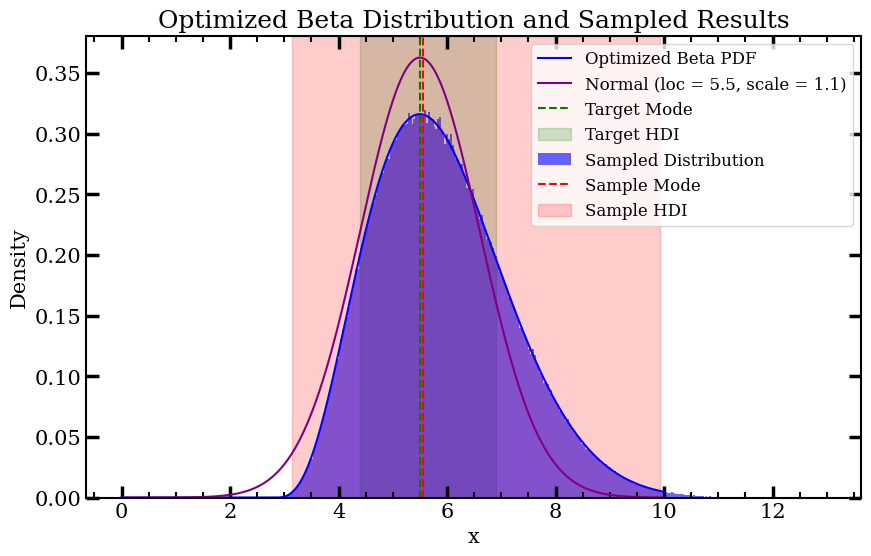

In [16]:
# Objective function for optimization
def objective(params, most_likely, hdi_lower, hdi_upper, CI):
    """
    Computes the error between the target mode/HDI and the Beta distribution's mode/HDI.

    Inputs:
    - params (list): [a, b, loc, scale] parameters of the Beta distribution.
    - most_likely (float): Target mode of the distribution.
    - hdi_lower (float): Lower bound of the target HDI.
    - hdi_upper (float): Upper bound of the target HDI.
    - CI (float): Credible interval for the HDI (e.g., 0.68 for 68%).

    Output:
    - float: Sum of squared differences between the target and sampled mode/HDI.
    """
    a, b, loc, scale = params

    # Ensure valid beta parameters
    if a <= 0 or b <= 0 or a > b or scale <= 0:
        return np.inf

    try:
        dist = ss.beta(a, b, loc=loc, scale=scale)
        sample = dist.rvs(size=int(1e6))
        sample_mode = az.plots.plot_utils.calculate_point_estimate('mode', sample)
        sample_hdi = az.hdi(sample, hdi_prob=CI)

        # Error metrics: HDI coverage + mode alignment
        return (
            (most_likely - sample_mode) ** 2 +
            (hdi_lower - sample_hdi[0]) ** 2 +
            (hdi_upper - sample_hdi[1]) ** 2
        )
    except Exception as e:
        print(f"Error in objective function: {e}, params: {params}")
        return np.inf


# Fit a Beta distribution to match target mode and HDI
def fit_beta_distribution(objective, most_likely, hdi_lower, hdi_upper, init_params, CI=0.68, tol=3e-1):
    """
    Optimizes Beta distribution parameters to match a target mode and HDI.

    Inputs:
    - objective (function): Objective function to minimize.
    - most_likely (float): Target mode of the Beta distribution.
    - hdi_lower (float): Lower bound of the target HDI.
    - hdi_upper (float): Upper bound of the target HDI.
    - init_params (list): Initial guess for [a, b, loc, scale].
    - CI (float): Credible interval for the HDI (default is 0.68).
    - tol (float): Tolerance for the optimization algorithm (default is 3e-1).

    Output:
    - list: Optimized parameters [a, b, loc, scale] or None if optimization fails.
    """
    # Parameter bounds
    bounds = np.array([(3.0, 5.0), (10.0, 13.0), (2, 3), (11, 14)])

    # Create an initial population with the initial guess
    init_population = [init_params] + [
        np.random.uniform(low=b[0], high=b[1], size=len(init_params))
        for b in bounds
    ]

    # Run differential evolution with parallel workers
    result = differential_evolution(
        objective,
        bounds,
        strategy='best1bin',
        tol=tol,
        maxiter=1000,
        workers=-1,  # Use all available cores
        args=(most_likely, hdi_lower, hdi_upper, CI),  # Pass additional arguments to the objective function
        init=init_population  # Use the initial population
    )

    # Check if the optimization was successful
    if not result.success:
        print("Optimization failed:", result.message)
        return None

    # Return the optimized parameters
    return result.x


# Example usage
most_likely = 5.5  # Target mode
hdi_lower = 4.4    # Lower bound of the 68% HDI
hdi_upper = 6.9    # Upper bound of the 68% HDI
CI = 0.68          # Credible interval
init_params = [4.277607762521999, 12.724793025434032, 2.811799926582254, 12.28667225478282]  # Initial guess for [a, b, loc, scale]

# Fit the Beta distribution
#optimized_params = fit_beta_distribution(objective, most_likely, hdi_lower, hdi_upper, init_params, CI=CI)
optimized_params = init_params # These come from not small amount of trial and error (lol) but they seen to work alright


if optimized_params is not None:
    a, b, loc, scale = optimized_params
    print(f"Optimized parameters: {a}, {b}, {loc}, {scale}")

    # Define the optimized Beta distribution
    dist = ss.beta(a, b, loc=loc, scale=scale)

    # Generate samples from the optimized distribution
    samples = dist.rvs(size=int(1e6))

    # Calculate the sample mode and HDI
    sample_mode = az.plots.plot_utils.calculate_point_estimate('mode', samples)
    sample_hdi = az.hdi(samples, hdi_prob=0.997)

    print(f"Sample mode: {sample_mode}")
    print(f"Sample HDI: {sample_hdi}")

    # Plot the optimized Beta distribution
    x = np.linspace(0,10,1000)
    pdf = dist.pdf(x)

    plt.figure(figsize=(10, 6))
    plt.plot(x, pdf, label="Optimized Beta PDF", color="blue")
    plt.plot(x, ss.norm.pdf(x, loc=5.5, scale=1.1), label="Normal (loc = 5.5, scale = 1.1)", color="purple")
    plt.axvline(most_likely, color="green", linestyle="--", label="Target Mode")
    plt.axvspan(hdi_lower, hdi_upper, color="green", alpha=0.2, label="Target HDI")

    # Plot the sampled distribution
    plt.hist(samples, bins=300, density=True, alpha=0.6, label="Sampled Distribution", color="blue")
    plt.axvline(sample_mode, color="red", linestyle="--", label="Sample Mode")
    plt.axvspan(sample_hdi[0], sample_hdi[1], color="red", alpha=0.2, label="Sample HDI")

    plt.xlabel("x")
    plt.ylabel("Density")
    plt.title("Optimized Beta Distribution and Sampled Results")
    plt.legend(fontsize=12)
    plt.show()
else:
    print("Optimization failed.")

GX 339-4 Mode: 2.0 - 0.6 + 4.1 Msun
GX 339-4 HDI: [1.40050361 6.02924622] Msun
Swift J1753.5-0127 Mode: 0.9 - 0.6 + 1.7 Msun
Swift J1753.5-0127 HDI: [0.30200792 2.59880302] Msun
H 1743-322 Mode: 3.0 - 0.7 + 0.9 Msun
H 1743-322 HDI: [2.24770817 3.88506352] Msun
MAXI J1348-630 Mode: 0.8 - 0.3 + 6.1 Msun
MAXI J1348-630 HDI: [0.43109379 6.84206824] Msun
XTE J1752-223 Mode: 0.3 - 0.2 + 11.1 Msun
XTE J1752-223 HDI: [ 0.11439553 11.41453397] Msun
MAXI J1836-194 Mode: 0.1 - 0.0 + 0.7 Msun
MAXI J1836-194 HDI: [0.03168061 0.79381567] Msun
Swift J1727.8-1613 Mode: 25.0 - 9.7 + 18.7 Msun
Swift J1727.8-1613 HDI: [15.29531783 43.69227255] Msun


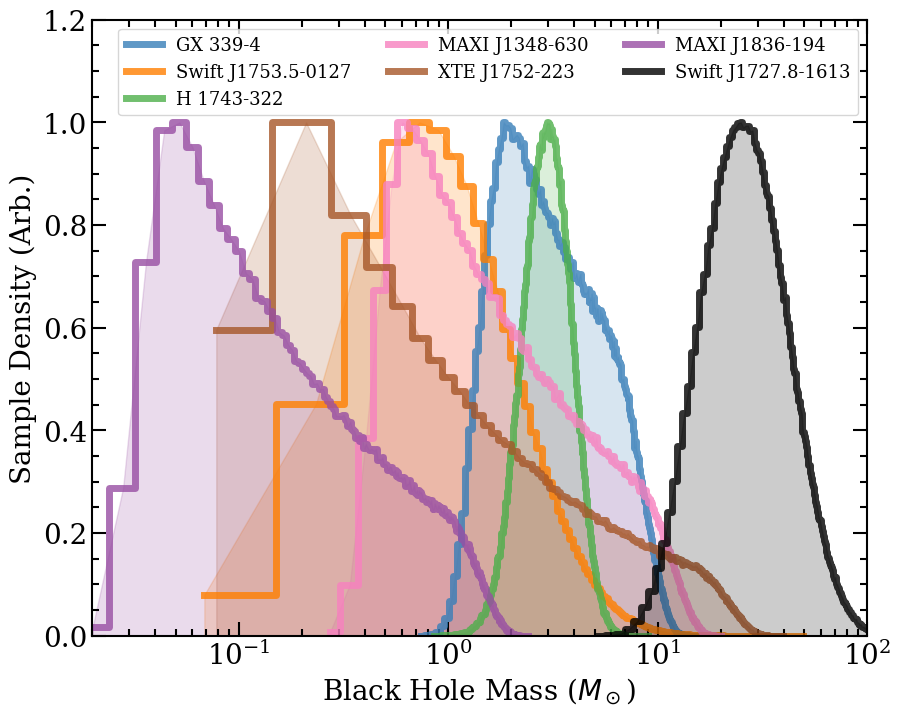

In [17]:
# Load archival data for black holes
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')  # Black hole catalog data
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T  # Data for Swift J1727.8-1613

# Create a dictionary to store black hole properties
BH_dict = {
    'GX 339-4': {
        'D0': 8.0,  # Reference distance (kpc)
        'Dprior': ss.uniform(loc=6, scale=9),  # Uniform prior for distance (kpc)
        'Mprior': [4, 11],  # Mass range prior (solar masses)
        'Lmax': np.nanmax(data['Lx'][data['Name'] == 'GX 339-4'])  # Max X-ray luminosity (erg/s)
    },
    'Swift J1753.5-0127': {
        'D0': 8.0,
        'Dprior': CustomDistribution(likelihood, r, pi=swiftJ1753[0], dpi=swiftJ1753[1]),  # Distance prior from Gaia parallax
        'Mprior': 0,  # Mass range prior not specified
        'Lmax': np.nanmax(data['Lx'][data['Name'] == 'Swift J1753.5-0127'])
    },
    'H 1743-322': {
        'D0': 8.0,
        # 'Dprior': ss.uniform(loc=5, scale=5),
        'Dprior': ss.norm(loc=8.5, scale=0.8),
        'Mprior': [9, 14],
        'Lmax': np.nanmax(data['Lx'][data['Name'] == 'H 1743-322'])
    },
    'MAXI J1348-630': {
        'D0': 2.2,
        'Dprior': ss.uniform(loc=1, scale=4),
        'Mprior': [5, 20],
        'Lmax': np.nanmax(data['Lx'][data['Name'] == 'MAXI J1348-630'])
    },
    'XTE J1752-223': {
        'D0': 8.0,
        'Dprior': ss.uniform(loc=2, scale=23),
        'Mprior': [5, 55],
        'Lmax': np.nanmax(data['Lx'][data['Name'] == 'XTE J1752-223'])
    },
    'MAXI J1836-194': {
        'D0': 10.0,
        'Dprior': ss.uniform(loc=4, scale=21),
        'Mprior': [5, 12],
        'Lmax': np.nanmax(data['Lx'][data['Name'] == 'MAXI J1836-194'])
    },
    'Swift J1727.8-1613': {
        'D0': 5.5,
        'Dprior': ss.beta(a=4.28, b=12.72, loc=2.81, scale=12.29),  # Beta prior for distance
        'Mprior': 0,
        'Lmax': np.nanmax(swJ1727[1])
    }
}

# Function to estimate and plot the mass distribution of a black hole
def estimate_mass(BH, name, ax, col, fedd=1.0, n_sample=int(1e6)):
    """
    Estimate and plot the mass distribution of a black hole.

    Parameters:
    - BH (dict): Black hole properties (distance prior, luminosity, etc.).
    - name (str): Name of the black hole (used for labeling the plot).
    - ax (matplotlib.axes.Axes): Axis object for plotting.
    - col (str): Color for the plot.
    - fedd (float): Eddington fraction (default is 1.0).
    - n_sample (int): Number of samples for Monte Carlo simulation (default is 1e6).

    Returns:
    - hdi (tuple): 68% highest density interval (HDI) of the mass distribution.
    - mode (float): Mode of the mass distribution.
    """

    # Sample bolometric correction factor and distance from priors
    tbol = ss.uniform.rvs(loc=3, scale=2, size=n_sample)  # Bolometric correction factor
    D = BH['Dprior'].rvs(size=n_sample)  # Distance samples
    L = 0.1 * BH['Lmax'] * np.random.randn(n_sample) + BH['Lmax']  # X-ray luminosity samples

    # Calculate the mass distribution
    M = 0.8 * (D / BH['D0']) ** 2 * (L / 1e38) * tbol / fedd

    # Compute and normalize the histogram
    counts, bins = np.histogram(M, bins=300)
    normalized_counts = counts / counts.max()  # Normalize to max value of 1

    # Plot the normalized histogram as steps
    if name == 'Swift J1727.8-1613':
        ax.step(bins[:-1], normalized_counts, where='mid', label=name, alpha=0.8, color='k', lw=5, zorder=1000)
        ax.fill_between(bins[:-1], normalized_counts, alpha=0.2, color='k', zorder=1000)
    else:
        ax.step(bins[:-1], normalized_counts, where='mid', label=name, alpha=0.8, lw=5, color=col)
        ax.fill_between(bins[:-1], normalized_counts, alpha=0.2, color=col)

    # Compute the mode and HDI of the distribution
    hdi, mode = compute_hdi_and_mode(M, hdi_prob=0.68) 
    return hdi, mode

# Define colors for plotting (color-blind friendly palette)
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

# Plotting loop
fig, ax = plt.subplots(figsize=(10, 8))
for k, (name, BH) in enumerate(BH_dict.items()):
    # Estimate and plot the mass distribution for each black hole
    hdi, mode = estimate_mass(BH, name, ax, col=colors[k], fedd=1.0, n_sample=int(1e6))
    print(f"{name} Mode: {mode:.1f} - {mode - hdi[0]:.1f} + {hdi[1] - mode:.1f} Msun")
    print(f"{name} HDI: {hdi} Msun")

# Customize the plot
ax.set_xlabel(r'Black Hole Mass ($M_\odot$)', fontsize=20)
ax.set_ylabel('Sample Density (Arb.)', fontsize=20)
ax.tick_params(axis='both', which='minor', direction='in', length=5, width=1.5, top=True, right=True)
ax.tick_params(axis='both', which='major', direction='in', length=10, width=1.5, top=True, right=True, labelsize=20)
ax.legend(fontsize=13, loc='upper right', ncol=3)
ax.set_xlim(2e-2, 1e2)
ax.set_ylim(0, 1.2)
ax.set_xscale('log')
plt.savefig('plots/LR_Mass.pdf')
plt.show()

# RANDOM WORK AND NOTES

## Linear-space to demonstrate consistent fitting results

In [ ]:
# ---------------------------------
# Initialize the fitting functions
# ---------------------------------

# Broken Power law
def broken_plaw(Lx, beta1, beta2, Ltran, Amp):

    func = BrokenPowerLaw1D(amplitude = Amp, x_break = Ltran, alpha_1 = -1. * beta1, alpha_2 = -1 * beta2)
    
    return func(Lx)

# Single Power law 
def plaw(Lx, beta1, Amp):
    
    return Amp * Lx ** beta1

# Adapted from: https://stackoverflow.com/questions/79028892/how-to-get-errors-on-a-cubic-spline-interpolation-python-splrep-splev
def variance(model, x, p, Cp):
    
    def proxy(q):
        return model(x, *q)
    
    def projection(J):
        return J @ Cp @ J.T
    
    Jp = nd.Jacobian(proxy)(p)
    Cy = np.apply_along_axis(projection, 1, Jp)

    # Return square root to get sigma
    return Cy ** 0.5

# -------------------
# Fit only the decay
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
swJ1727 = swJ1727[:,(swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = (swJ1727[4] > 5e30)
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables -- need to scale for numerical reasons
scale = 1e31
x  = swJ1727[1] / scale
y  = swJ1727[4] / scale
dy = np.amax(swJ1727[5:7], axis=0) / scale

# Once again, use relative errors to maximize the fit errors conservatively
# These arrays correspond to [guess, lower_bound, upper_bound]
par_names = ['Beta1', 'Beta2', 'Ltrans', 'A']
beta1  = [0.3, 0.01, 2.0]
beta2  = [1.4, 0.01, 2.0]
Ltrans = np.array([5e36, 5e34, 5e38]) / scale
A = [1, -1e8, +1e8]
guess = np.array([beta1, beta2, Ltrans, A]).T
decay_fit, decay_cov = curve_fit(broken_plaw, x, y, sigma = dy, absolute_sigma = False, p0 = guess[0], bounds = (guess[1], guess[2]))

# Calculate chi-square values from the fit
decay_chi2 = np.sum((y - broken_plaw(x, *decay_fit)) ** 2 / dy ** 2) 
decay_dof = len(y) - len(par_names)

# Scale the fit parameters and print them
decay_fit_scaled  = decay_fit.copy() 
decay_fit_scaled[2:] *= scale
decay_err = np.diag(decay_cov) ** 0.5
decay_err[2:] *= scale

print('\nThe Decay only fit has a chi2 of {:.2f} for {} dof'.format(decay_chi2, decay_dof))
for k, par in enumerate(par_names):
    print('{}: {:.3e} +/- {:.3e}'.format(par, decay_fit_scaled[k], decay_err[k]))


# -------------------
# Fit all the data
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
swJ1727 = swJ1727[:,(swJ1727[-1] < 0.5)]

# Define the fitting variables -- need to scale for numerical reasons
x  = swJ1727[1] / scale
y  = swJ1727[4] / scale
dy = np.amax(swJ1727[5:7], axis=0) / scale
dx = swJ1727[2:4] / scale

# Once again, use relative errors to maximize the fit errors conservatively
# These arrays correspond to [guess, lower_bound, upper_bound]
par_names = ['Beta1', 'Beta2', 'Ltrans', 'A']
beta1  = [0.3, 0.01, 2.0]
beta2  = [1.4, 0.01, 2.0]
Ltrans = np.array([5e36, 5e34, 5e38]) / scale
A = [1, -1e8, +1e8]
guess = np.array([beta1, beta2, Ltrans, A]).T
total_fit, total_cov = curve_fit(broken_plaw, x, y, sigma = dy, absolute_sigma = False, p0 = guess[0], bounds = (guess[1], guess[2]))

# Calculate chi-square values from the fit
total_chi2 = np.sum((y - broken_plaw(x, *total_fit)) ** 2 / dy ** 2) 
total_dof = len(y) - len(par_names)

# Scale the fit parameters and print them
total_fit_scaled  = total_fit.copy() 
total_fit_scaled[2:] *= scale
total_err = np.diag(total_cov) ** 0.5
total_err[2:] *= scale

print('\nThe total fit has a chi2 of {:.2f} for {} dof'.format(total_chi2, total_dof))
for k, par in enumerate(par_names):
    print('{}: {:.3e} +/- {:.3e}'.format(par, total_fit_scaled[k], total_err[k]))


# ---------------------------------
# Do a bit of comparative plotting
# ---------------------------------

# Reload the the non upperlimit data
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_5p5kpc.txt').T
swJ1727 = swJ1727[:,(swJ1727[-1] < 0.5)]

# Initialize plot
font_size=20
fig, ax = plt.subplots(figsize=(8,8))

ax.set_ylabel(r'Radio Luminosity [5 GHz] (erg s$^{-1}$ ' + str(scale) + ')', fontsize= font_size, fontfamily='serif')
ax.set_xlabel(r'X-ray Luminosity [1-10 keV] (erg s$^{-1}$ '  + str(scale) + ')', fontsize= font_size, fontfamily='serif')
ax.tick_params(axis='both', which='minor', direction='in',length=5,width=1.5,top=True,right=True)
ax.tick_params(axis='both', which='major', direction='in',length=10,width=1.5,top=True,right=True, labelsize=15)
ax.minorticks_on()

# Plot SwJ1727 data
ax.errorbar(x, y, xerr = dx, yerr = dy, fmt = '^', color = 'k', mfc = 'k', ms = 8, zorder = 10000)

# Broken Power Laws -- Decay
xmod = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
plt.plot(xmod, broken_plaw(xmod, *decay_fit), c ='b', ls = '-', zorder=1000)
for k in range(1000):
     sample_fit = np.random.multivariate_normal(decay_fit, decay_cov.astype(np.float64), tol = 1e-6)
     ax.plot(xmod, broken_plaw(xmod, *sample_fit), alpha=0.15, c = 'grey')


# Broken Power Law -- Total
plt.plot(xmod, broken_plaw(xmod, *total_fit), c ='r', ls = '-')

# For illustration purposes, show the rise points increase by a factor of 2.5
ytemp = y.copy()
ytemp[ytemp > 5e30 / scale] *= 2.5
ax.errorbar(x, ytemp, xerr = dx, yerr = dy, fmt = '^', color = 'k', mfc = 'w', ms = 8)

# Formatting Junk
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

## Luminosity conversion

In [ ]:
# X-ray conversion
xray_flux = np.genfromtxt('SWJ1717_Files/Xray_flux.txt', skip_header = 1).T
lx = 4 * np.pi * xray_flux[1] * (5.5 * 3.086e+21) ** 2
print(lx[1])
print(4 * np.pi * (5.5 * 3.086e+21) ** 2 * 1e-7) # * xray_flux[1,1] / 1e-7 * (5.5 / 5.5) ** 2)

# Radio conversion
lr = 1e-26 * 4 * np.pi * 5.0e9 * (3.5 * 3.086e+21) ** 2 * radio_flux[1] * (5.0 / radio_flux[-2]) ** matched_alpha[1]
print(lr[1])

print(1e-26 * 4 * np.pi * 5.0e9 * (5.5 * 3.086e+21) ** 2) # * radio_flux[1,1] * (5.0 / radio_flux[-2,1]) ** matched_alpha[1,1] * (3.5 / 5.5) ** 2)


In [ ]:
E = np.linspace(1,10,10000)
Ebol = np.linspace(0.5,10e3,10000)
gamma = 1.7
F = E * E ** (-gamma) * np.exp(-E / 200)
Fbol =  Ebol * Ebol ** (-gamma) * np.exp(-Ebol / 200)

plt.plot(E,F, zorder=100)
plt.plot(Ebol,Fbol)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,10)
plt.show()


print(np.trapz(Fbol, Ebol) / np.trapz(F,E))

### Transitional Luminosity work

The critical mass accretion rate (which is related to the, luminosity) can be expressed as (1207.3113). They seem to define $\dot{M}_{edd} = 10L_{edd}/c^2 \rightarrow L_{edd} = \epsilon \dot{M}_{edd}c^2$:

$$
\dot{M}_c \sim 5\alpha^2\theta_e^{5/3}\dot{M}_{edd}
$$

where $\alpha{sim}0.1$ (but can go as high as $\sim$1; 1801.07203) and the electron temperature is parameterized with $\theta_e \equiv kT_e / m_ec^2$ where it seems to be $kT_e \sim 10{-}1000\,$ keV (1912.12145)

In [ ]:
# Function to calculate the electron temperature proxy (dimensionless)
def theta_e(kT):
    '''
    Calculate the dimensionless electron temperature proxy (theta_e).

    Parameters:
    - kT (float or array): Electron temperature in keV.

    Returns:
    - theta_e (float or array): Dimensionless electron temperature proxy, defined as kT / (m_e * c^2).
    '''

    # Convert temperature from keV to erg
    kT = kT * 1e3 * 1.60218e-12  # 1 keV = 1.60218e-9 erg

    # Constants
    m_e = 9.11e-28  # Electron mass in grams
    c = 2.998e10  # Speed of light in cm/s

    # Calculate the electron temperature proxy
    theta_e = kT / (m_e * c ** 2)  # Dimensionless temperature

    return theta_e ** (3/2)


print(5 * 0.2 ** 2  * 1.26e38 * 10 * theta_e(100))

print(1e-3/0.3 ** 2 / theta_e(30))